In [1]:
step=91
extent="intra" #"intra") #inter or intra # irrelevant for MovingWindow
Dataset='Jake'
var_names = ["Rg","T","NEE","VPD","H","LE"]
nv=len(var_names)

tau_min=0
tau_max=5
min_len=5
attribute2='_RgNotDriver'


In [2]:
alpha_level=0.1

In [3]:
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from tigramite import plotting as tp
from tigramite.data_processing import DataFrame

import PIL
import cartopy.crs as ccrs
import matplotlib.lines as lines
from matplotlib.widgets import Slider, CheckButtons, Button,LassoSelector#, RadioButtons
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.path import Path
import scipy as sp
from scipy.spatial.distance import pdist, squareform
import numpy as np
import time
import xarray as xr

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
j=30
dimRedType='TSNE_cont_links_agg_red_%s'%j

In [7]:
data=pd.read_csv("../Data/df_val_q_t_y_m_%s_%s_%s_%s_%s_%s%s_Tier1_Clustering80,8,0.1.csv" % (Dataset,extent,step,tau_max,min_len,alpha_level,attribute2),index_col=0)
data['Season']=pd.Categorical(data['Season'], ['Jan','Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'])
#data.columns.values[49:265]=data.columns.values[49:265].astype(int)


/home/christopher/anaconda3/envs/tigraClustOldPandas/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (266,268,269,346,347,352) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data.replace('Maj','May',inplace=True)

In [ ]:
data=pd.read_csv("../Data/df_val_q_t_y_m_%s_%s_%s_%s_%s_%s_Tier1.csv" % (Dataset,extent,step,tau_max,min_len,alpha_level),index_col=0)
data['Season']=pd.Categorical(data['Season'], ['Jan','Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'])

In [8]:
data.groupby('KoeppenGeigerGroup').Tower.nunique()#.count() #unique()

KoeppenGeigerGroup
1.0     6
2.0    32
3.0    33
4.0    44
5.0     1
Name: Tower, dtype: int64

In [ ]:
6+32+33+44+1

In [ ]:
data.keys().values#[data["Median_%s_Space_TowerSeason" % dimRedType]==False]

In [ ]:
#data=pd.read_csv("../Data/df_val_q_intra_min_len5_TSNE.csv",index_col=0)
#data.columns.values[49:265]=data.columns.values[49:265].astype(int)

#data['Season']=pd.Categorical(data['Season'], ['Jan','Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'])

In [9]:
def distcorr(X, Y,Y_distance_mat=False):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    if Y_distance_mat==False:
        b = squareform(pdist(Y))
    else:
        b=Y
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor


# calc distance correlation vector for each link with dimred space

def dcorvector(data,dimRedType,descriptors):
    vector=[]
    Y=data[dimRedType]
    b = squareform(pdist(Y))
    for link in descriptors:
        X=data[link].dropna()
        indices=X.index
        dcor=distcorr(X.loc[indices],b[:,indices.astype(int)][indices.astype(int),:],Y_distance_mat=True)
        vector.append(dcor)
    return vector



In [10]:
labels=[]
matrix=np.zeros((nv,nv,tau_max-tau_min+1),'U8')
for i,d in enumerate(var_names):
    for j,r in enumerate(var_names):
        for t in range(tau_min,tau_max+1):
       # labels.append(d + "→" +r)
            matrix[i,j,t]=d + "→" +r+str(t)

matrix.reshape(nv*nv*(tau_max-tau_min+1))


cont_links_agg=[]
lag_links_agg=[]
tau_max=5
#matrix=np.zeros((nv,nv,tau_max-tau_min+1),'U8')
for i,d in enumerate(var_names):
    for j,r in enumerate(var_names):
        #for t in [0,1,2,3,4,5]:
        #labels.append(d + "→" +r+':1-6')
        cont_links_agg.append(d + "→" +r+':0')
        lag_links_agg.append(d + "→" +r+':1-%s'%(tau_max))
           # matrix[i,j,t]=d + "→" +r+str(t)

lag_links_agg_red=[]
for i,link in enumerate(lag_links_agg):
 #   if not link[:link.index('→')] in link[link.index('→'):]:
        if not 'Rg' in link[link.index('→'):]:
            lag_links_agg_red.append(link)

lag_links_agg_red_noAC=[]
for i,link in enumerate(lag_links_agg):
    if not link[:link.index('→')] in link[link.index('→'):]:
        if not 'Rg' in link[link.index('→'):]:
            lag_links_agg_red_noAC.append(link)

cont_links_agg_red=[]
for i,link in enumerate(cont_links_agg):
    if not link[:link.index('→')] in link[link.index('→'):]:
        if not 'Rg' in link[link.index('→'):]:
            if  link[link.index('→')+1:link.index(':')] + '→' + link[:link.index('→')] +':0' not in cont_links_agg_red:
                cont_links_agg_red.append(link)
                
cont_links_agg_red_NEE=[]
cont_links_agg_red_NEE=[link for link in cont_links_agg_red if 'NEE' in link]

cont_links_agg_red_LE=[]
cont_links_agg_red_LE=[link for link in cont_links_agg_red if 'LE' in link]

cont_links_agg_red_noNEE=[]
cont_links_agg_red_noNEE=[link for link in cont_links_agg_red if 'NEE' not in link]

cont_links_agg_red_NEELE=[]
cont_links_agg_red_NEELE=[link for link in cont_links_agg_red if 'NEE' in link or 'LE' in link ]

cont_links_agg_red_noNEELE=[]
cont_links_agg_red_noNEELE=[link for link in cont_links_agg_red if 'NEE' not in link and 'LE' not in link]

In [11]:
# chnage sign of NEE
data.loc[:,[link for link in data.keys() if 'NEE' in link]]*=-1# data.loc[:,[link for link in data.keys() if 'NEE' in link and '→' in link]].mul(-1)

data.loc[:,np.where(['NEE' in l for l in matrix.reshape(nv*nv*(tau_max-tau_min+1))])[0].astype(str)]*=-1 

# 1st plot: comparison dimred quality

### plot produced by Guido

# 2nd Plot: Coloring dimredspace by link variables

In [ ]:
cont_links_agg_red

In [12]:
networkexcerpt=cont_links_agg_red

In [13]:
time_start = time.clock()
dcor_vec=dcorvector(data,[dimRedType+'1',dimRedType+'2'],networkexcerpt)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

df=pd.DataFrame(columns=['Links','Ranking'])

df['Links']=networkexcerpt

df['Ranking']=dcor_vec

/home/christopher/anaconda3/envs/tigraClustOldPandas/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


118.861929


/home/christopher/anaconda3/envs/tigraClustOldPandas/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [14]:
df.sort_values('Ranking',ascending=False,inplace=True)

In [16]:
color=list(df['Links'].values)# + ['GPP_mean','Rg_max','P_mean','LE_mean','VPD_max']

dimReddim1='1'
dimReddim2='2'
num=len(color)

fig2, ax2 = plt.subplots(ncols=5, nrows=np.ceil(num/5).astype(int),gridspec_kw=dict(hspace=0,wspace=0),figsize=(12,np.ceil(num/5).astype(int)*2.5))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for i in range(num):
    ax=fig2.axes[i]
    sc= ax.scatter(data.loc[:,dimRedType+dimReddim1],data.loc[:,dimRedType+dimReddim2],c=data.loc[:,color[i]],s=1,cmap='coolwarm',alpha=1,edgecolors='face',marker='o',lw=0,vmin=-1,vmax=1)
   # a.set_ylabel(matrix.reshape(nv*nv*6)[int(dcor_vec_sort[i])])
    text=color[i][:-2]
  #  if text[0:2]!='Rg':
   #     text=text.replace('→',r'$-$')
    ax.annotate(text,(0.6,0.98),xycoords='axes fraction', va="top", ha="center")
    ax.annotate(round(df['Ranking'].values[i],2),(0.9,0.98),xycoords='axes fraction', va="top", ha="center")

  #  ax.set_facecolor('gray')  
    ax.tick_params(labelbottom=False, labelleft=False)
#axins = inset_axes(ax,
 #              width="5%",  # width = 5% of parent_bbox width
  #             height="100%",  # height : 50%
   #            loc='lower right',
    #           bbox_to_anchor=(0, 0., 1, 1),
     #          bbox_transform=ax.transAxes,
      #         borderpad=0,
       #        )
        
ax_cbar=fig2.add_axes([0.3, 0.08, 0.4, 0.02])
cbar_cbar=fig2.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1), cmap='coolwarm'), cmap='coolwarm', cax=ax_cbar,ax=fig2.axes, orientation='horizontal')
#cbar_cbar.set_ticks(np.arange(1, 13, 1))
#cbar_cbar.set_ticklabels(np.arange(1, 13, 1))
cbar_cbar.set_label('Link strength') #('MCI cross-dependence value')
 
#cbar=fig2.colorbar(sc, cax=axins, orientation='horizontal')
  #  cbar.set_label(color[i])
#fig2.tight_layout()
#format_axes(fig)
plt.show()

In [17]:
#fig2.savefig('/home/christopher/Documents/SecondPaper/Plots/Gradient_Links_%s.pdf' % alpha_level, bbox_inches='tight')
fig2.savefig('/home/christopher/Documents/SecondPaper/Plots/Gradient_Links_%s%s.png' % (alpha_level,attribute2), bbox_inches='tight',dpi=300)

# Fig coloring dimred space by climatic variables

In [ ]:
keys=['Rg_mean_y', 'T_mean_y', 'NEE_mean_y', 'VPD_mean_y', 'H_mean_y',
       'LE_mean_y', 'P_mean_y', 'GPP_mean_y', 'lon', 'lat',
       'Rg_mean_s', 'T_mean_s', 'NEE_mean_s', 'VPD_mean_s', 'H_mean_s',
       'LE_mean_s', 'P_mean_s', 'GPP_mean_s', 'Rg_mean', 'Rg_max',
       'Rg_min', 'T_mean', 'T_max', 'T_min', 'NEE_mean', 'NEE_max',
       'NEE_min', 'VPD_mean', 'VPD_max', 'VPD_min', 'H_mean', 'H_max',
       'H_min', 'LE_mean', 'LE_max', 'LE_min', 'P_mean', 'P_max', 'P_min',
       'GPP_mean', 'GPP_max', 'GPP_min', 'SWC1_mean', 'SWC1q_mean',
       'SWC2_mean', 'SWC2q_mean',]
#'Year',
 #     'Season_num', 'Tower_num', 'IGBP_num',
  #     'Vegetation_num', 'PeakGrowingMonth','PeakGrowingMonth_Year','KoeppenClassGrid','KoeppenGeigerGroup']

In [ ]:
keys=['lat', 'lon']

In [ ]:
data.columns.values

In [ ]:
data.KoeppenGeigerGroup

In [ ]:
keys=['GPP_mean','Rg_mean','LE_mean','H_mean','NEE_mean','T_mean','VPD_mean','P_mean']


In [ ]:
time_start = time.clock()
dcor_vec=dcorvector(data,[dimRedType+'1',dimRedType+'2'],keys)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

In [ ]:
df_2=pd.DataFrame(columns=['Links','Ranking'])

df_2['Links']=keys

df_2['Ranking']=dcor_vec

df_2.sort_values('Ranking',ascending=False,inplace=True)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


color= list(df_2['Links'].values) 
dimensions=['','',r'$gC m^{-2} d^{-1}$',r'$W m^{-2}$',r'$W m^{-2}$',r'$W m^{-2}$',r'$^{\circ}C$',r'$gC m^{-2} d^{-1}$',r'$hPa$','%',r'$mm d^{-1}$','%','','']


dimReddim1='1'
dimReddim2='2'
num=len(color)

fig3, ax3 = plt.subplots(ncols=2, nrows=np.ceil(num/4).astype(int),gridspec_kw=dict(hspace=0.1,wspace=0.35),figsize=(6,np.ceil(num/4).astype(int)*2.5)+0.1*np.ceil(num/4).astype(int)*2.5)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for i in range(num):
    ax=fig3.axes[i]
    temp_c=data.loc[:,color[i]].copy()
    temp_c.loc[temp_c>temp_c.quantile(0.99)]=temp_c.quantile(0.99)
    temp_c.loc[temp_c<temp_c.quantile(0.01)]=temp_c.quantile(0.01)
    sc= ax.scatter(data.loc[:,dimRedType+dimReddim1],data.loc[:,dimRedType+dimReddim2],c=temp_c,s=1,cmap='gnuplot',alpha=1,edgecolors='face',marker='o',lw=0)
   # a.set_ylabel(matrix.reshape(nv*nv*6)[int(dcor_vec_sort[i])])
    ax.annotate(color[i].replace('_',' ').replace('1','').replace('mean',''),(0.02,0.98),xycoords='axes fraction', va="top", ha="left")
    ax.annotate(round(df_2[df_2.Links==color[i]]['Ranking'].values[0],2),(0.85,0.98),xycoords='axes fraction', va="top", ha="center")

  #  ax.set_facecolor('gray')  
    ax.tick_params(labelbottom=False, labelleft=False)
    axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0, 0.05, 1.02, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cbar=fig3.colorbar(sc, cax=axins)
    if color[i]=='GPP_mean' or color[i]=='NEE_mean' or color[i]=='T_mean':
        cbar.set_label(dimensions[i],labelpad=-5)
    else:
        cbar.set_label(dimensions[i])
 #   ax.set_facecolor('gray')    
fig3.tight_layout()
#format_axes(fig)
plt.show()

In [ ]:
fig3.savefig('/home/christopher/Documents/SecondPaper/Plots/lat_lon.png',dpi=400)

In [ ]:
fig3.savefig('/home/christopher/Documents/SecondPaper/Plots/Gradient_Climate_%s.png'  % alpha_level,dpi=400)

In [ ]:
keys=['Bowenratio','SWC1_mean','IGBP_num','KoeppenGeigerGroup']

In [11]:
data['Bowenratio']=data.H_mean/data.LE_mean

data.loc[data['Bowenratio']<0,'Bowenratio']=-1

In [ ]:
time_start = time.clock()
dcor_vec=dcorvector(data,[dimRedType+'1',dimRedType+'2'],keys)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

In [ ]:
df_3=pd.DataFrame(columns=['Links','Ranking'])

df_3['Links']=keys

df_3['Ranking']=dcor_vec

df_3.sort_values('Ranking',ascending=False,inplace=True)

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)




In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


color= list(df_3['Links'].values)
dimensions=['',r'$mm\ d^{-1}$','','','']


dimReddim1='1'
dimReddim2='2'
num=len(color)

fig3, ax3 = plt.subplots(ncols=4, nrows=np.ceil(num/4).astype(int),gridspec_kw=dict(hspace=0.1,wspace=0.3),figsize=(15,np.ceil(num/4).astype(int)*3)+0.1*np.ceil(num/4).astype(int)*3)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for i in range(num):
    ax=fig3.axes[i]
    temp_c=data.loc[:,color[i]].copy()
    if color[i]=='KoeppenGeigerGroup':
        sc= ax.scatter(data.loc[:,dimRedType+dimReddim1],data.loc[:,dimRedType+dimReddim2],c=temp_c,s=1,cmap=discrete_cmap(5, 'gnuplot'),alpha=1,edgecolors='face',marker='o',lw=0)
    elif color[i]=='IGBP_num':
        sc= ax.scatter(data.loc[:,dimRedType+dimReddim1],data.loc[:,dimRedType+dimReddim2],c=temp_c,s=1,cmap='tab10',alpha=1,edgecolors='face',marker='o',lw=0)
    else:
        temp_c.loc[temp_c>temp_c.quantile(0.95)]=temp_c.quantile(0.95)
        sc= ax.scatter(data.loc[:,dimRedType+dimReddim1],data.loc[:,dimRedType+dimReddim2],c=temp_c,s=1,cmap='gnuplot',alpha=1,edgecolors='face',marker='o',lw=0)
   # a.set_ylabel(matrix.reshape(nv*nv*6)[int(dcor_vec_sort[i])])
    ax.annotate(color[i].replace('_',' ').replace('1','').replace('mean','').replace('num','').replace('KoeppenGeigerGroup','Koeppen Geiger'),(0.02,0.98),xycoords='axes fraction', va="top", ha="left")
    ax.annotate(round(df_3[df_3.Links==color[i]]['Ranking'].values[0],2),(0.85,0.98),xycoords='axes fraction', va="top", ha="center")

  #  ax.set_facecolor('gray')  
    ax.tick_params(labelbottom=False, labelleft=False)
    axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0, 0.05, 1.02, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cbar=fig3.colorbar(sc, cax=axins)
    cbar.set_label(dimensions[i])
    
    if color[i]=='KoeppenGeigerGroup':
        cbar=fig3.colorbar(sc, cax=axins)
        cbar.set_label(dimensions[i])
        cbar.set_ticks(np.linspace(1.5,4.5,5))
        cbar.set_ticklabels(['A','B','C','D','E'])
    elif color[i]=='IGBP_num':
        cbar=fig3.colorbar(sc, cax=axins)
        cbar.set_label(dimensions[i])
        cbar.set_ticks(np.linspace(0.5,9.5,10))
        cbar.set_ticklabels(['GRA', 'ENF', 'SAV', 'WSA', 'EBF', 'MF', 'CRO', 'WET', 'OSH','DBF'])
        
 #   ax.set_facecolor('gray')    

fig3.tight_layout()
#format_axes(fig)
plt.show()

In [ ]:
fig3.savefig('/home/christopher/Documents/SecondPaper/Plots/Gradient_Meta_%s.png'  % alpha_level,dpi=400)

# DimRed Schematic

In [12]:
from scipy.spatial import distance_matrix

from sklearn import linear_model

from scipy.spatial import ConvexHull

In [13]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return PIL.Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

def add_prototype_networks(coords,val_matrix,threshold,ax):
#    fig_inset,ax_inset=plt.subplots(figsize=(1,1),)
 #   fig_inset.axes[0].set_facecolor('blue')
    graph=tp.plot_graph(
  #      fig_ax=(fig_inset,ax_inset),
        figsize=(1.5,1.5),
        val_matrix=val_matrix,
        link_matrix=abs(val_matrix)>threshold,
    #    var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        arrow_linewidth=15,
        node_size=10,
     #   label_fontsize=15,
        node_label_size=0,
    #    curved_radius=0.5,
        link_label_fontsize=9,
        show_colorbar=False,
        )
    #convert network and add as artist
    graphPIL = fig2img ( graph[0] )    
    imagebox = OffsetImage(graphPIL, zoom=0.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,     
                        coords,
                   #     xybox=(0.2,0.2),
                        xycoords='data',
                     #   boxcoords="offset points",
                      #  pad=3,
                        frameon=False,
                        box_alignment=(0.5, 0.5),
                        bboxprops=dict(color='red'),
                      #  arrowprops=dict(
                       #     arrowstyle="->"
                        #            )
                       )
    return ab

In [14]:
def scatter_dimred_prototypes(clustering,threshold,figsize=(10,10),fig_ax=None):
 #   dimRedType='tSNE_cont_%s'%j
    if fig_ax==None:
        fig,ax=plt.subplots(figsize=figsize)
    else:
        fig,ax=fig_ax[0],fig_ax[1]
  #  ax.set_facecolor('gray')    
    temp=data[data["Median_%s_Space_TowerSeason" % dimRedType]==False]
    sc= ax.scatter(temp.loc[:,dimRedType+'1'],temp.loc[:,dimRedType+'2'],c=temp.loc[:,clustering],s=10,cmap='nipy_spectral',alpha=1,linewidths=0)#,vmin=-1,vmax=1)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
#    bbox_props = dict(boxstyle="larrow,pad=0.3", fc='white', ec="black", lw=2)
#    ax.text(140, 120, "Increase in mean precipitation", ha="right", va="top", rotation=0,
#                size=15,
#                bbox=bbox_props)

#    ax.text(160, 90, "Increase in maximal radiation", ha="right", va="top", rotation=62,
#                size=15,
#                bbox=bbox_props)

    fontsize=13
    bbox_props = dict(boxstyle="round4", fc='white', ec="grey", lw=1)
    ax.text(0.02, 0.98, "high precipitation\n high radiation", ha="left", va="top", rotation=0,
                size=fontsize,
                transform=ax.transAxes,
                bbox=bbox_props) 
    ax.text(0.98, 0.98, "medium precipitation\n medium radiation", ha="right", va="top", rotation=0,
                size=fontsize,
                transform=ax.transAxes,
                bbox=bbox_props) 

    ax.text(0.98, 0.02, "low precipitation\n low radiation", ha="right", va="bottom", rotation=0,
                size=fontsize,
                transform=ax.transAxes,
                bbox=bbox_props) 
    
    ax.text(0.02, 0.02, "low precipitation\n high radiation", ha="left", va="bottom", rotation=0,
                size=fontsize,
                transform=ax.transAxes,
                bbox=bbox_props)     
    
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc='white', ec="black", lw=2)
#    ax.text(-110, 40, "Decoupling and reversal of T connectivity", ha="center", va="center", rotation=65,
#                size=15,
#                bbox=bbox_props)

#    ax.text(-10, -102, "Decoupling and reversal of NEE connectivity", ha="center", va="center", rotation=0,
#                size=15,
#                bbox=bbox_props)

    bbox_props=dict(boxstyle="round4", fc='white',lw=0)
    ax.text(-52, 90, "4. Fully\n connected\n network", ha="center", va="center", rotation=0,
                size=fontsize,backgroundcolor='white', bbox=bbox_props,
                )

    ax.text(65, -60, "1. Sparsely\n connected\n network", ha="center", va="center", rotation=0,
                size=fontsize,backgroundcolor='white', bbox=bbox_props,
                )

    ax.text(65, 50, "3.\n NEE strongly,\n T sparsely\n connected", ha="center", va="center", rotation=0,
                size=fontsize,backgroundcolor='white', bbox=bbox_props,
                )
    ax.text(-70, -60, "2. T\n strongly,\n NEE,LE\n sparsely\n connected", ha="center", va="center", rotation=0,
                size=fontsize,backgroundcolor='white', bbox=bbox_props,
                )

    
    return fig, ax

def dimred_schematic(clustering,threshold,figsize=(10,10),fig_ax=None,plotnetworks=True,alpha=1):
    networkexcerpt=np.arange(0,nv*nv*(tau_max-tau_min+1)).astype(str)

     #   dimRedType='tSNE_cont_%s'%j
    if fig_ax==None:
        fig,ax=plt.subplots(figsize=figsize)
    else:
        fig,ax=fig_ax[0],fig_ax[1]
    
    data.loc[:,clustering]=data.loc[:,clustering].astype(int)
    
    hull={}
    coordcenter=(120,110)
    for c in data[clustering].unique():
        if c != -1:
            indices=np.where((data[clustering]==c) & ((data["Median_%s_Space_TowerSeason" % dimRedType]==False)))[0]
            hull[c]=ConvexHull(data.loc[indices,[dimRedType+'1',dimRedType+'2']])
            points=data.loc[indices,[dimRedType+'1',dimRedType+'2']].values

            
            highest_point=points[hull[c].vertices,1].argmax()

            ax.annotate(c,
            xy=(points[hull[c].vertices[highest_point],0], points[hull[c].vertices[highest_point],1]), xycoords='data',
            xytext=(-8, -15), textcoords='offset points',
            alpha=alpha,
            zorder=100
            )

      #      ax.plot(points[:,0], points[:,1], 'o')
            for simplex in hull[c].simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], 'k-',alpha=alpha)


       #     ax.plot(points[hull[c].vertices,0], points[hull[c].vertices,1], 'r--', lw=2)
       #     ax.plot(points[hull[c].vertices[highest_point],0], points[hull[c].vertices[highest_point],1], 'ro')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
#    for var,length in zip(['Rg_max'],[30]):
 #       lm = linear_model.LinearRegression()
  #      indices=data[[dimRedType+'1',dimRedType+'2',var]].dropna().index
   #     X=data.loc[indices,[dimRedType+'1',dimRedType+'2']]
    #    y=data.loc[indices,var]
     #   model = lm.fit(X,y)
     #   ax.arrow(coordcenter[0],coordcenter[1],lm.coef_[0]*length,lm.coef_[1]*length,width=1,color='r')
     #   ax.text(s=var,x=coordcenter[0]+lm.coef_[0]*length/2,y=coordcenter[1]+lm.coef_[1]*length 
      #          )
    if plotnetworks==True:
        num_labels=data[clustering].max()
        for i in range(num_labels+1):
          #  print(i)
          #  fig,axs=plt.subplots(ncols=3,nrows=1,figsize=(6,2),gridspec_kw=dict(hspace=0,wspace=0) )
      #      centroid1=distance_matrix(data[data[clustering]==i][networkexcerpt],data[data[clustering]==i][networkexcerpt]).sum(axis=1).argmin()
            centroid2=distance_matrix(data[data[clustering]==i][[dimRedType+'1',dimRedType+'2']],data[data[clustering]==i][[dimRedType+'1',dimRedType+'2']]).sum(axis=1).argmin()
            network_mean=data[data[clustering]==i][networkexcerpt].mean(axis=0)
      #      network_c1=data[data[clustering]==i].loc[:,networkexcerpt].iloc[centroid1]#
      #      network_c2=data[data[clustering]==i].loc[:,networkexcerpt].iloc[centroid2]#
            val_matrix_mean=network_mean.values.reshape(nv,nv,-1)
      #      val_matrix_c1=network_c1.values.reshape(nv,nv,-1)
      #      val_matrix_c2=network_c2.values.reshape(nv,nv,-1)

            val_matrix_mean[:,:,1]=np.eye(nv)*threshold
            coords=data[data[clustering]==i].loc[:,[dimRedType+'1',dimRedType+'2']].iloc[centroid2].values
       #     print(coords)
  #          ab=add_prototype_networks(coords,val_matrix_mean,threshold,ax)
   #         ax.add_artist(ab)
         #   ax.scatter(coords[0],coords[1],c='red')
            axins = inset_axes(ax,
                           width=0.8,  # width = 5% of parent_bbox width
                           height=0.8,  # height : 50%
                           loc='center',
                           bbox_to_anchor=coords,
                           bbox_transform=ax.transData,
                           borderpad=0,
                           )
            axins.patch.set_alpha(0)
            
            graph=tp.plot_graph(
                fig_ax=(fig,axins),
                figsize=(0.8,0.8),
                val_matrix=val_matrix_mean,
                link_matrix=abs(val_matrix_mean)>=threshold,
            #    var_names=var_names,
                link_colorbar_label='cross-MCI',
                node_colorbar_label='auto-MCI',
                arrow_linewidth=15,
                node_size=10,
             #   label_fontsize=15,
                node_label_size=0,
            #    curved_radius=0.5,
                link_label_fontsize=9,
                show_colorbar=False,
                )
            
            
   
    if plotnetworks==True:
        # add legend network
        axins = inset_axes(ax,
            width=0.8,  # width = 5% of parent_bbox width
            height=0.8,  # height : 50%
            loc='upper right',
            bbox_to_anchor=(0.96,0.96),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )
        axins.patch.set_alpha(0)
        axins.set_title('Node labels',fontsize=13)
        val_matrix=np.zeros((nv,nv,2))
        val_matrix[:,:,1]=np.eye(nv)*threshold
        legend=tp.plot_graph(
            fig_ax=(fig,axins),
            figsize=(3.,3.),
            val_matrix=val_matrix,
            link_matrix=abs(val_matrix)>=threshold,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            arrow_linewidth=15,
            node_size=12,
         #   label_fontsize=15,
            node_label_size=13,
        #    curved_radius=0.5,
            link_label_fontsize=9,
            show_colorbar=False,
            )
        axins = inset_axes(ax,
            width=1.8,  # width = 5% of parent_bbox width
            height=0.1,  # height : 50%
            loc='lower right',
            bbox_to_anchor=(0.95,0.07),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )
        axins.patch.set_alpha(0)

        #ax_cbar=fig2.add_axes([0.3, 0.08, 0.4, 0.02])
        cbar_cbar=fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1), cmap='RdBu_r'), cmap='RdBu', cax=axins,ax=ax, orientation='horizontal')
        #cbar_cbar.set_ticks(np.arange(1, 13, 1))
        #cbar_cbar.set_ticklabels(np.arange(1, 13, 1))
        cbar_cbar.set_label('MCI cross-dependence value',fontsize=13)

    return fig, ax

In [41]:
cluster0=9

cluster_centers=data.groupby('Clustering_%s'% dimRedType)[[dimRedType+'1',dimRedType+'2']].mean().round().astype(int)

cluster_distance=distance_matrix(cluster_centers.loc[0:,:],cluster_centers.loc[cluster0,:][np.newaxis,:])

cluster_distance_df=pd.DataFrame(index=cluster_centers.loc[0:,:].index,data={'Distance':cluster_distance.reshape(-1),'Ranking':cluster_distance.argsort(axis=0).reshape(-1).argsort(axis=0)})
cluster_distance_df.loc[-1,:]=[np.nan,-1]
cluster_distance_df.Ranking=cluster_distance_df.Ranking.astype(int)
cluster_distance_df=cluster_distance_df.join(cluster_centers)

data['DistanceClusterCentersToCluster0']=np.nan
data['ClusterCenterTSNE1']=np.nan
data['ClusterCenterTSNE2']=np.nan
for c in data['Clustering_%s'% dimRedType].unique():
    data.loc[data['Clustering_%s'% dimRedType]==c,['DistanceClusterCentersToCluster0','ClusterCenterTSNE1','ClusterCenterTSNE2']]=cluster_distance_df.loc[c,['Ranking',dimRedType+'1',dimRedType+'2']].values
    

data.DistanceClusterCentersToCluster0=data.DistanceClusterCentersToCluster0.astype(int)
data.ClusterCenterTSNE1=data.ClusterCenterTSNE1.astype(int)
data.ClusterCenterTSNE2=data.ClusterCenterTSNE2.astype(int)


In [ ]:
[link for link in data.keys() if 'NEE' in link and '→' in link]

In [19]:
data.DistanceClusterCentersToCluster0

0        14
1        -1
2         1
3         1
4         1
5         1
6         1
7         1
8        -1
9        14
10       -1
11        1
12        1
13        1
14        1
15        1
16        1
17        1
18       -1
19       14
20       14
21       14
22        1
23        7
24       -1
25        7
26        1
27       14
28       14
29       -1
         ..
11370    -1
11371    -1
11372    -1
11373    -1
11374    -1
11375    -1
11376    -1
11377    -1
11378    -1
11379    -1
11380    -1
11381    -1
11382    -1
11383    -1
11384    -1
11385    -1
11386    -1
11387    -1
11388    -1
11389    -1
11390    -1
11391    -1
11392    -1
11393    -1
11394    -1
11395    -1
11396    -1
11397    -1
11398    -1
11399    -1
Name: DistanceClusterCentersToCluster0, Length: 11400, dtype: int64

In [17]:
data[data.DistanceClusterCentersToCluster0==0]['Rg→NEE:0'].mean()

-0.6713515856969756

In [ ]:
data=data

In [ ]:
[link for link in data.keys() if 'NEE' in link and '→' in link]

In [46]:
fig4,ax4=plt.subplots(1,2,figsize=(20,10))

scatter_dimred_prototypes('DistanceClusterCentersToCluster0',0.2,figsize=(8,8),fig_ax=(fig4,ax4[0]))

dimred_schematic('DistanceClusterCentersToCluster0',0.2,figsize=(8,8),fig_ax=(fig4,ax4[1]),plotnetworks=True)

#ax4[1].texts[0].set_position((10,-35))

#ax4[1].texts[8].set_position((2,-20))

(<Figure size 1440x720 with 21 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9afd7ebba8>)

(<Figure size 1440x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff6d3a7e668>)

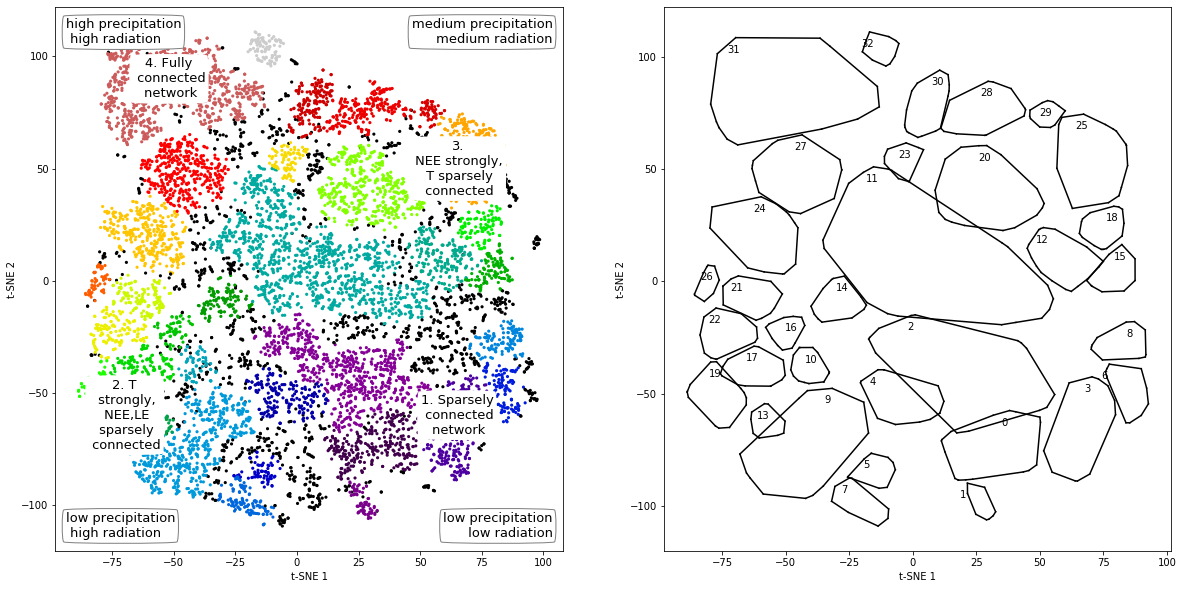

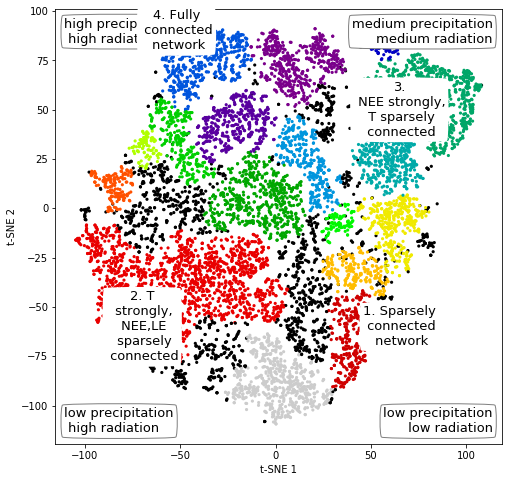

In [44]:
fig=scatter_dimred_prototypes('DistanceClusterCentersToCluster0',0.2,figsize=(8,8))


In [ ]:
fig4.savefig('/home/christopher/Documents/IMPRS/Test2.png',dpi=300)

In [ ]:
ax4[1].texts[0].set_position((10,-35))

ax4[1].texts[8].set_position((2,-20))

In [ ]:
ax4[1].texts[8]

In [ ]:
fig4.savefig('/home/christopher/Documents/SecondPaper/Plots/DimRedSpace_%sfine.pdf' % alpha_level, bbox_inches='tight')

In [ ]:
data

# 5th Plot

### trajectory of towers

In [24]:
from adjustText import adjust_text
import string

In [25]:
data_plot=data
def plot_mean_and_cluster_networks(tower, threshold=0.1,clustering='Clustering'):

    fig,ax=plt.subplots(2,12,gridspec_kw=dict(hspace=0.1,wspace=0),figsize=(24,4))
    fig.axes[0].set_ylabel("Tower")
    fig.axes[12].set_ylabel("Cluster")
    indices=data_plot[(data_plot['Tower']==tower) & (data_plot['CentroidTSNESpace_TowerSeason']==True)].sort_values('Season').index

    cluster=data_plot.loc[indices,[clustering,'Season']].sort_values('Season')#['Clustering'].values

    for i,ind in enumerate(indices):
        val_matrix=data_plot.loc[ind,networkexcerpt].values.reshape(nv,nv,-1).astype(float)
        fig.axes[i].set_title('%s'%(data_plot.loc[ind,'Season']))
        tp.plot_graph(
        fig_ax=(fig,fig.axes[i]),
        figsize=(1.,1.),
        val_matrix=val_matrix,
        link_matrix=abs(val_matrix)>0.0,
    #    var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        arrow_linewidth=15,
        node_size=10,
     #   label_fontsize=15,
        node_label_size=0,
    #    curved_radius=0.5,
        link_label_fontsize=9,
        show_colorbar=False,
        )


        network_mean=data[data[clustering]==cluster[clustering].values[i]][networkexcerpt].mean(axis=0)
        val_matrix_mean=network_mean.values.reshape(nv,nv,-1)

        val_matrix_mean[:,:,1:]=np.zeros((6,6,5))
        fig.axes[12+i].set_title(cluster['Clustering'].values[i],y=0.9)
        tp.plot_graph(
        fig_ax=(fig,fig.axes[12+i]),
        figsize=(1.,1.),
        val_matrix=val_matrix_mean,
        link_matrix=abs(val_matrix_mean)>threshold,
    #    var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        arrow_linewidth=15,
        node_size=10,
     #   label_fontsize=15,
        node_label_size=0,
    #    curved_radius=0.5,
        link_label_fontsize=9,
        show_colorbar=False,
        )

        if cluster['Season'].values[i] != data_plot.loc[ind,'Season']:
            print('Error:Seasons do not match')
            break

In [26]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('Set3'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,zorder=1, ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha, zorder=zorder)
    
    if ax==None:
        ax = plt.gca()
    
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [27]:
def show_trajectory(towers,year,ax,clustering='Clustering',marker='o',ls='-',lw=3,c=None):
    for tower in towers:
        m = cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=11), cmap=cmap_month)

        temp=data_plot[(data_plot["Tower"]==tower) & (data_plot["Year"]==year) & (data_plot["Median_%s_Space_TowerSeason" % dimRedType]==False)].sort_values('Season')

        # plot the lines
        #for i in temp.index:
        #    sc=ax.scatter(temp.loc[i,dimRedType+'1'], temp.loc[i,dimRedType+'2'],color= 'black', #m.to_rgba(temp.loc[i,'Season_num'])
         #                 cmap=cmap_month, marker='.',s=200)
        ax.plot(temp[dimRedType+'1'], temp[dimRedType+'2'],marker=marker,ls=ls,lw=lw,color=c,label=' '+str(year))
        texts = [ax.text(temp.loc[i,dimRedType+'1'], temp.loc[i,dimRedType+'2'], '$%s$'%temp.loc[i,'Season'], ha='center', va='center') for i in temp.index]
        #adjust_text(texts)
        ax.legend()
        
      #  '$%s$'%temp.loc[i,'Season']

In [47]:
data_plot=data

In [29]:
    
def show_trajectory_mean(towers,ax,clustering='Clustering', uncertainty=False):
    for tower in towers:
        m = cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=11), cmap=cmap_month)
     #   ax_month=fig.add_axes([0.9, 0.15, 0.03, 0.7])
      #  cbar_month=fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=1, vmax=12), cmap=cmap_month), cmap=cmap_month, cax=ax_month,ax=fig.axes)
       # cbar_month.set_ticks(np.arange(1, 13, 1))
        #cbar_month.set_ticklabels(np.arange(1, 13, 1))
        #cbar_month.set_label('Month')
     #   temp= data_plot[data_plot["Tower"]==tower].groupby('Season').mean().reset_index()
        temp = data_plot[(data_plot["Median_%s_Space_TowerSeason" % dimRedType]==True) & (data_plot["Tower"]==tower)].sort_values('Season')
        #for i in temp.index:
        #    sc=ax.scatter(temp.loc[i,dimRedType+'1'], temp.loc[i,dimRedType+'2'],color= 'black', #m.to_rgba(temp.loc[i,'Season_num']),
        #                  cmap=cmap_month, marker='$%s$'%temp.loc[i,'Season'],s=200)
        meantraj = ax.plot(temp.iloc[[i for i in range(0,len(temp))]+[0]][dimRedType+'1'], temp.iloc[[i for i in range(0,len(temp))]+[0]][dimRedType+'2'],'o-',linewidth=3,label=tower[0:6])
        texts = [ax.text(temp.loc[i,dimRedType+'1'], temp.loc[i,dimRedType+'2'], '$%s$'%temp.loc[i,'Season'], ha='center', va='center') for i in temp.index]
        ax.legend()
        
        if uncertainty:
            temp = data_plot[(data_plot["Median_%s_Space_TowerSeason" % dimRedType]==False) & (data_plot["Tower"]==tower)]
            ax.plot(temp[dimRedType+'1'], temp[dimRedType+'2'],'-',color=meantraj[0].get_c(),alpha=0.5,linewidth=1)

       # fig.axes[0].colorbar(sc)

In [30]:
def plot_temp(tower,years,ax):
    temp=data_plot[(data_plot["Tower"]==tower)].sort_values(['Season','Year'])[['T_mean','Season','Year',"Median_%s_Space_TowerSeason" % dimRedType]]
    cats=list(temp['Season'].cat.categories)

    for y in years:
        indices=[cats.index(m) for m in temp[temp.Year==y]['Season'].values]
        ax.plot(indices,temp[temp.Year==y]['T_mean'].values,'o-',label=y)

    indices=[cats.index(m) for m in temp[(temp["Median_%s_Space_TowerSeason" % dimRedType]==True)]['Season'].values]
    ax.plot(indices,temp[(temp["Median_%s_Space_TowerSeason" % dimRedType]==True)]['T_mean'].values,'o-',label='Mean Network')
    ax.plot(temp[temp["Median_%s_Space_TowerSeason" % dimRedType]==False].groupby('Season')['T_mean'].median().values,'o-',label='median Temp')

    ax.legend()

    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax.set_xticklabels(cats)

In [31]:
def plot_prec(tower,years,ax):
    temp=data_plot[(data_plot["Tower"]==tower)].sort_values(['Season','Year'])[['P_mean','Season','Year',"Median_%s_Space_TowerSeason" % dimRedType]]
    cats=list(temp['Season'].cat.categories)

    indices=[cats.index(m) for m in temp[(temp["Median_%s_Space_TowerSeason" % dimRedType]==True)]['Season'].values]
    ax.plot(indices,temp[(temp["Median_%s_Space_TowerSeason" % dimRedType]==True)]['P_mean'].values,'o-',label='median networks')
    sns.lineplot(data=temp[temp["Median_%s_Space_TowerSeason" % dimRedType]==False].sort_index(),x='Season',y='P_mean',ax=ax,err_style='band',ci='sd',color=ax.get_lines()[-1].get_color(),lw=0)

    for y in temp.Year.unique():
        indices=[cats.index(m) for m in temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False)]['Season'].values]
        ax.plot(indices,temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False) ]['P_mean'].values,'o-',lw=0.5,c='#1f77b4',marker=None)

    for y in years:
        indices=[cats.index(m) for m in temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False)]['Season'].values]
        ax.plot(indices,temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False) ]['P_mean'].values,'o-',label=y)

#    ax.plot(temp[temp["Median_%s_Space_TowerSeason" % dimRedType]==False].groupby('Season')['P_mean'].median().values,'o-k',alpha=0.5,label='median Prec')

   # ax.legend()
    ax.get_legend().remove()
    
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax.set_xticklabels(cats)
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean daily precipitation / mm')

In [48]:
index_mean_networks=10038

In [34]:
def mean_climatic_conditions(var,towers,years=None,fig_ax=None,figsize=(10,10)):
    if fig_ax==None:
        fig,ax=plt.subplots(len(var),1,figsize=(10,10))
    else:
        fig,ax=fig_ax[0],fig_ax[1]
        ax.remove()
    
    for i,v in enumerate(var):
        ax=fig.add_subplot(len(var),2,(i+1)*2,label=i)
        for t in towers:
            temp=data.loc[data.Tower==t,['Season','Year',v]].loc[:index_mean_networks]
            temp_mean=data.loc[data.Tower==t,['Season',v]].loc[index_mean_networks:].sort_values('Season')
            ax.plot(temp_mean['Season'],temp_mean[v])
            sns.lineplot(data=temp.sort_index(),x='Season',y=v,ax=ax,err_style='band',ci=100,color=ax.get_lines()[-1].get_color(),lw=0)
            if years != None:
                for y in years:
                    temp=data_plot[(data_plot["Tower"]==tower)].sort_values(['Season','Year'])[[v,'Season','Year',"Median_%s_Space_TowerSeason" % dimRedType]]
                    cats=list(temp['Season'].cat.categories)
                    indices=[cats.index(m) for m in temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False)]['Season'].values]
                    ax.plot(indices,temp[(temp.Year==y) & (temp["Median_%s_Space_TowerSeason" % dimRedType]==False) ][v].values,'o-',label=y)
            if v=='Bowenratio':
                ax.set_ylim(-1,10)


In [ ]:
%matplotlib inline

In [49]:
data['Bowenratio']=data.H_mean/data.LE_mean

#data.loc[data['Bowenratio']<0,'Bowenratio']=np.nan

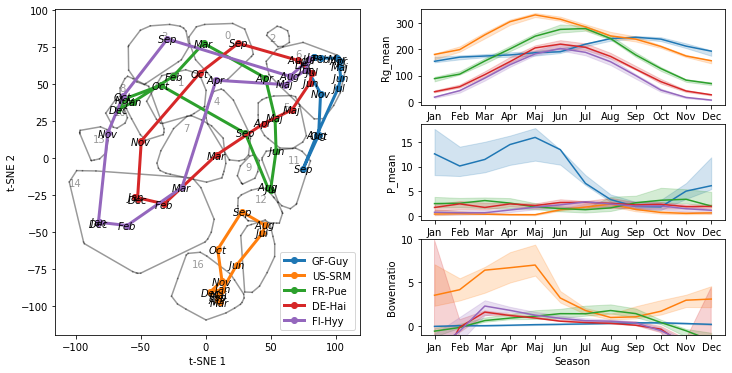

In [50]:
cmap_month='Paired'

towers=['GF-Guy.DD.2004.2014.nc','US-SRM.DD.2004.2014.nc','FR-Pue.DD.2000.2014.nc','DE-Hai.DD.2000.2012.nc','FI-Hyy.DD.1996.2014.nc']
#towers=['RU-Fyo.DD.1998.2014.nc', 'US-Ha1.DD.1991.2012.nc', 'CH-Cha.DD.2005.2014.nc','BE-Bra.DD.1996.2014.nc','BE-Vie.DD.1996.2014.nc','DK-Sor.DD.1996.2014.nc']
fig5,ax5 = plt.subplots(1,2,gridspec_kw=dict(hspace=0.1,wspace=0.2),figsize=(12,6))
dimred_schematic('DistanceClusterCentersToCluster0',0.2,fig_ax=(fig5,ax5[0]),figsize=(8,8),plotnetworks=False,alpha=0.4)
show_trajectory_mean(towers,ax5[0],uncertainty=False)
mean_climatic_conditions(['Rg_mean','P_mean','Bowenratio'],towers,fig_ax=(fig5,ax5[1]))

In [51]:
ax5[0].texts

[Text(-8, -15, '14'),
 Text(-8, -15, '1'),
 Text(-8, -15, '7'),
 Text(-8, -15, '4'),
 Text(-8, -15, '16'),
 Text(-8, -15, '15'),
 Text(-8, -15, '6'),
 Text(-8, -15, '5'),
 Text(-8, -15, '2'),
 Text(-8, -15, '0'),
 Text(-8, -15, '11'),
 Text(-8, -15, '9'),
 Text(-8, -15, '3'),
 Text(-8, -15, '8'),
 Text(-8, -15, '13'),
 Text(-8, -15, '10'),
 Text(-8, -15, '12'),
 Text(83.25653025, 68.215051, '$Jan$'),
 Text(88.73942975, 67.73483350000001, '$Feb$'),
 Text(101.12343125, 67.654514, '$Mar$'),
 Text(102.9671616, 65.4991438, '$Apr$'),
 Text(102.9224635, 61.61262675, '$Maj$'),
 Text(103.87742375, 54.10997875, '$Jun$'),
 Text(102.032922, 47.69238920000001, '$Jul$'),
 Text(85.50105400000001, 15.770208219999995, '$Aug$'),
 Text(74.713723, -7.5782843285714305, '$Sep$'),
 Text(86.839428, 15.696748200000002, '$Oct$'),
 Text(88.35002366666667, 43.76539906666667, '$Nov$'),
 Text(76.1064446, 63.39317500000001, '$Dec$'),
 Text(12.4614231, -88.75789916666668, '$Jan$'),
 Text(9.40033155, -93.1345565000000

In [52]:
texts=ax5[0].texts
adjust_text(texts,ax=ax5[0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))

500

<Figure size 432x288 with 0 Axes>

In [53]:
fig5.subplots_adjust(hspace=0.04)

In [54]:
for n, ax in enumerate(fig5.axes):
    ax.text(-0.12, 0.9, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=16)
    
    

In [55]:
# change y labels
fig5.axes[1].set_ylabel(r'Radiation (Wm$^{-2}$)')
fig5.axes[2].set_ylabel(r'Precipitation (mm)')
fig5.axes[3].set_ylabel('Bowen ratio')
fig5.axes[2].set_yscale('log')

In [56]:
fig5.axes[3].set_yscale('log')

In [57]:
fig5.axes[3].set_ylim(0.02,13)

(0.02, 13)

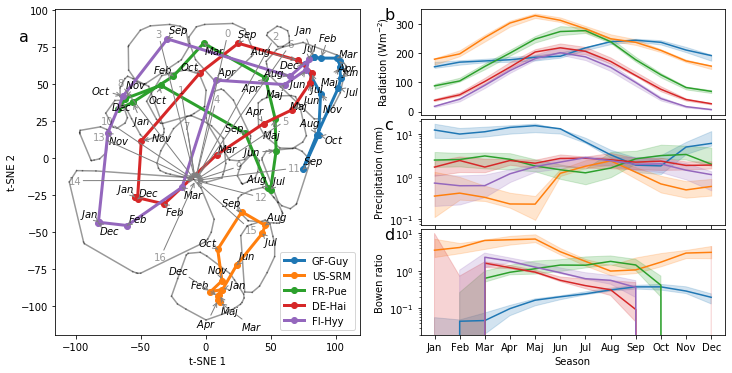

In [58]:
fig5

In [59]:
fig5.axes[3].texts

[Text(-0.12, 0.9, 'd')]

In [ ]:
del fig5.axes[3].texts[-3:]

In [ ]:
fig5.axes[0].texts

In [ ]:
fig5.savefig('/home/christopher/Documents/SecondPaper/Plots/TrajectoriesMeanRgPBowenNew.pdf',bbox_inches='tight')

In [ ]:
fig5.align_ylabels(ax5)#.align_ylabels()

In [ ]:
fig5

In [ ]:
#fig5.axes[3].set_ylim(-1,10)
fig5.axes[3].set_yscale()

# fig 6 anomalies

In [ ]:
%matplotlib inline

In [66]:
data.replace('Maj','May',inplace=True)

In [61]:
def plot_traj_prec(tower,years,fig_ax=None,uncertainty=False):
    if fig_ax==None:
        fig,ax=plt.subplots(1,2,figsize=(12,6))
    else:
        fig,ax=fig_ax[0],fig_ax[1]
        
#    ax[0].set_title(tower[0:6],fontsize=16,loc='left')
    ax[0].text(0.02,0.98,tower[0:6], transform=ax[0].transAxes,size=13,va='top')
    dimred_schematic('DistanceClusterCentersToCluster0',0.2,alpha=0.5,figsize=(10,10),plotnetworks=False,fig_ax=(fig,ax[0]))

    show_trajectory_mean([tower],ax[0],uncertainty=uncertainty)

    for year in years:
        show_trajectory([tower],year,ax[0])
    
   # mean_climatic_conditions(['P_mean'],[tower],years=[2003],fig_ax=(fig,ax[1]))
    plot_prec(tower,years,ax[1])
  #  texts=ax[0].texts[25:]
 #   adjust_text(texts,ax=ax[0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
    return fig, ax

In [ ]:
import seaborn as sns

In [ ]:
cmap_month='Paired'


500

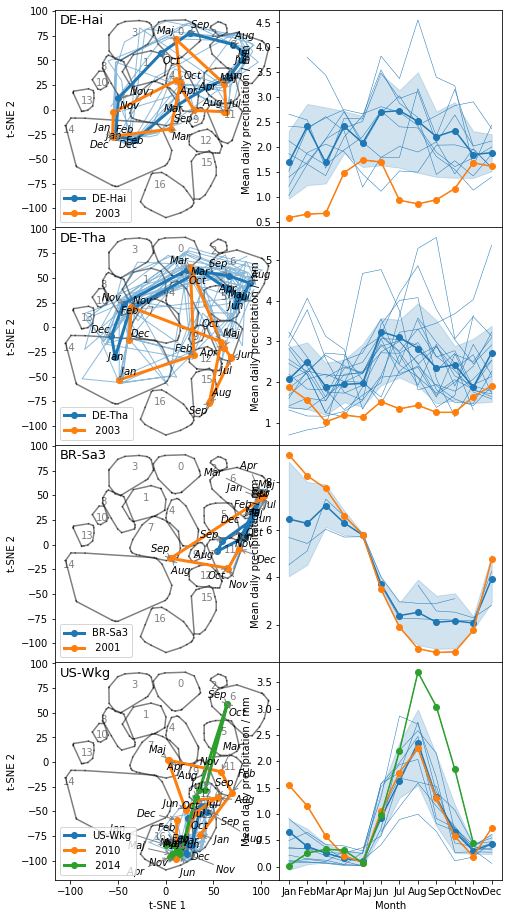

In [62]:
fig7,ax7=plt.subplots(4,2,gridspec_kw=dict(hspace=0.,wspace=0.),figsize=(8,16))

tower='DE-Hai.DD.2000.2012.nc'#,'DE-Lnf.DD.2002.2012.nc','DE-Tha.DD.1996.2014.nc']
plot_traj_prec(tower,[2003],fig_ax=(fig7,ax7[0,:]),uncertainty=True)


tower='DE-Tha.DD.1996.2014.nc'
plot_traj_prec(tower,[2003],fig_ax=(fig7,ax7[1,:]),uncertainty=True)

tower='BR-Sa3.DD.2000.2004.nc'
plot_traj_prec(tower,[2001],fig_ax=(fig7,ax7[2,:]),uncertainty=True)

tower='US-Wkg.DD.2004.2014.nc'
plot_traj_prec(tower,[2010,2014],fig_ax=(fig7,ax7[3,:]),uncertainty=True)


#fig7.subplots_adjust(hspace=0)

texts=ax7[0,0].texts[25:]
adjust_text(texts,ax=ax7[0,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[1,0].texts[25:]
adjust_text(texts,ax=ax7[1,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[2,0].texts[25:]
adjust_text(texts,ax=ax7[2,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[3,0].texts[25:]
adjust_text(texts,ax=ax7[3,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))




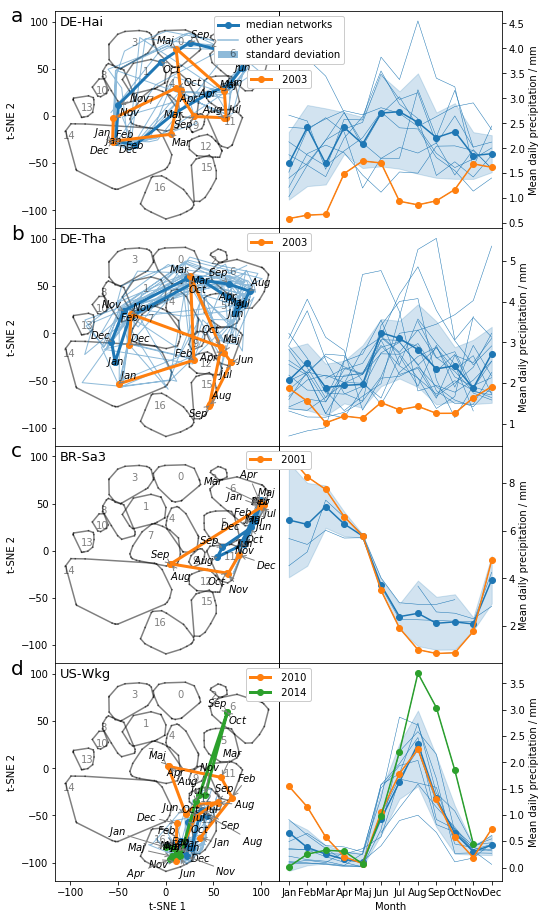

In [63]:
[ax7[i,1].yaxis.set_label_position("right") for i in range(ax7.shape[0])]
[ax7[i,1].yaxis.tick_right() for i in range(ax7.shape[0])]


for n, ax in enumerate(fig7.axes[::2]):
    ax.text(-0.2, 0.95, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20)
    
    ylimtop=ax.get_ylim()
    ax.set_ylim(ylimtop[0],ylimtop[1]+10)

    

[ax.set_xticklabels([]) for ax in fig7.axes[:-2]]
[ax.set_xticks([]) for ax in fig7.axes[:-2]]
[ax.set_xlabel('') for ax in fig7.axes[:-2]]

#adjust legend    
# add elements to legend 1
handles,labels=ax7[0,0].get_legend_handles_labels()
labels[0]='median networks'
line=matplotlib.lines.Line2D([0], [0], color='#1f77b4', linewidth=1.5, linestyle='-',label='other years',alpha=0.5)
patch=matplotlib.patches.Patch(color='#1f77b4', label='standard deviation',alpha=0.5,edgecolor=None,lw=0)

legend1=ax7[0,0].legend(handles=[handles[0],line,patch],labels=[labels[0],line.get_label(),patch.get_label()],loc='upper center',bbox_to_anchor=(1,1),frameon=True,fancybox=True,framealpha=1,facecolor='white')
ax7[0,0].add_artist(legend1)
ax7[0,1].set_zorder(-1)

legend=ax7[0,0].legend(handles=handles[1:],loc='upper center',bbox_to_anchor=(1,0.75),frameon=True,fancybox=True,framealpha=1,facecolor='white')


for i in range(1,ax7.shape[0]):
    handles,labels=ax7[i,0].get_legend_handles_labels()
    labels[0]='median'
    legend=ax7[i,0].legend(handles=handles[1:],loc='upper center',bbox_to_anchor=(1,1),frameon=True,fancybox=True,framealpha=1,facecolor='white')
    legend.set_zorder(10)
    
    ax7[i,1].set_zorder(-1)
    
fig7

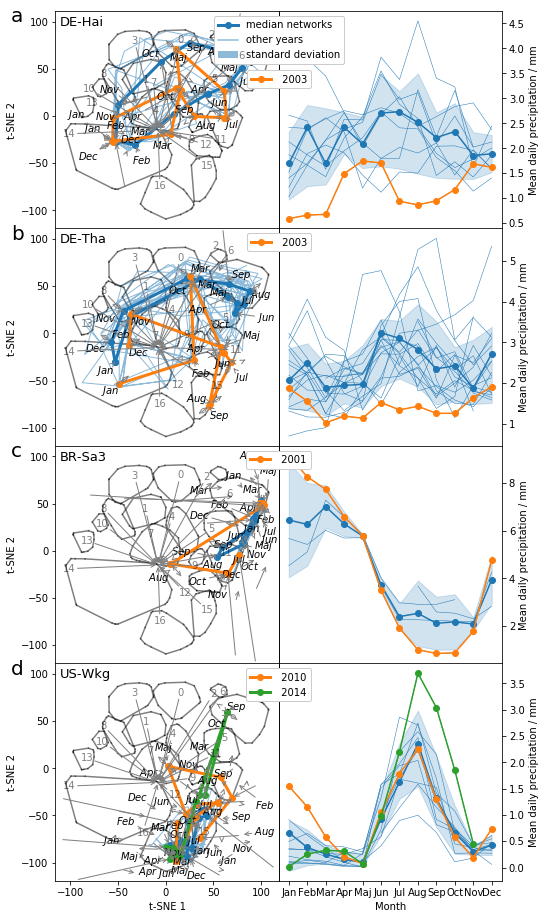

<Figure size 432x288 with 0 Axes>

In [67]:
texts=ax7[0,0].texts[1:-1]
adjust_text(texts,ax=ax7[0,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[1,0].texts[1:-1]
adjust_text(texts,ax=ax7[1,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[2,0].texts[1:-1]
adjust_text(texts,ax=ax7[2,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))
texts=ax7[3,0].texts[1:-1]
adjust_text(texts,ax=ax7[3,0],arrowprops=dict(arrowstyle='->', color='grey', alpha=1))


fig7

In [ ]:
test=ax7[2,0].texts[0]

In [ ]:
test

In [ ]:
test.set_x(0.2)

In [ ]:
test.set_y(0.99)

In [ ]:
#for n, ax in enumerate(fig7.axes[::2]):
#    ax.text(-0.17, 0.9, string.ascii_lowercase[n], transform=ax.transAxes, 
#            size=20)

In [ ]:
test=ax7[3,0]

In [ ]:
test.get_xticklabels()[1:4]

In [ ]:
test.get_xticks()

In [ ]:
test.set_xticks([-50,0,50])

In [ ]:
test.set_xticklabels(test.get_xticklabels()[1:4])

In [ ]:
fig7

In [ ]:
    fig7.savefig('/home/christopher/Documents/SecondPaper/Plots/Trajectories_Anomalies.pdf',bbox_inches='tight')

In [ ]:
import seaborn as sns

In [ ]:
data.Year.max()

# Supplementary Material Figure

In [ ]:
fig,ax=plt.subplots(8,2,figsize=(12,18),gridspec_kw=dict(hspace=0.0,wspace=0.01))

for i,var in enumerate(cont_links_agg_red):
    sns.boxplot(data=data.loc[:12545],y=var,x='DistanceClusterCentersToCluster0',ax=fig.axes[i])
    
[a.set_ylim(-0.999,1) for a in ax[:-1,:].reshape(-1)];

xticks=ax[0,0].get_xticks()

[a.set_xticks([]) for a in ax[:,:].reshape(-1) ];
[a.set_xlabel('') for a in ax[:,:].reshape(-1) ];

[a.yaxis.tick_right() for a in ax[:,-1].reshape(-1)];
[a.yaxis.set_label_position("right") for a in ax[:,-1].reshape(-1)];

[a.set_xlabel('Cluster') for a in ax[-1,:].reshape(-1) ];

ax[-1,0].set_xticks(xticks)
ax[-1,1].set_xticks(xticks)

In [ ]:
fig.savefig('/home/christopher/Documents/SecondPaper/Plots/BoxPlotsClustersLinks.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(4,2,figsize=(12,10),gridspec_kw=dict(hspace=0.0,wspace=0.01))

for i,var in enumerate(['GPP_mean','Rg_max','LE_mean','NEE_min','H_mean','T_mean','VPD_max','P_mean']):
    sns.boxplot(data=data.loc[:12545],y=var,x='DistanceClusterCentersToCluster0',ax=fig.axes[i])
    
ax[-1,-1].set_ylim(0,20)

[a.set_xticks([]) for a in ax[:-1,:].reshape(-1) ];
[a.set_xlabel('') for a in ax[:-1,:].reshape(-1) ];

[a.yaxis.tick_right() for a in ax[:,-1].reshape(-1)];
[a.yaxis.set_label_position("right") for a in ax[:,-1].reshape(-1)];

[a.set_xlabel('Cluster') for a in ax[-1,:].reshape(-1) ];

In [ ]:
fig,ax=plt.subplots(8,2,figsize=(18,18),gridspec_kw=dict(hspace=0.0,wspace=0.01))

for i,var in enumerate(keys):
    sns.boxplot(data=data.loc[:12545],y=var,x='DistanceClusterCentersToCluster0',ax=fig.axes[i])
    
ax[4,-1].set_ylim(0,10)
xticks=ax[0,0].get_xticks()

[a.set_xticks([]) for a in ax[:,:].reshape(-1) ];
[a.set_xlabel('') for a in ax[:,:].reshape(-1) ];

[a.yaxis.tick_right() for a in ax[:,-1].reshape(-1)];
[a.yaxis.set_label_position("right") for a in ax[:,-1].reshape(-1)];

[a.set_xlabel('Cluster') for a in ax[-1,:].reshape(-1) ];

ax[-1,0].set_xticks(xticks)
ax[-1,1].set_xticks(xticks)

In [ ]:
ax[0,0].set_ylabel('GPP (gC m$^-$ day$^-$)')
ax[1,0].set_ylabel(r'LE (W m$^{-2}$)')
ax[2,0].set_ylabel(r'H (W m$^{-2}$)')
ax[3,0].set_ylabel(r'VPD (%)')
ax[0,1].set_ylabel(r'Rg (W m$^{-2}$)')
ax[1,1].set_ylabel(r'NEE (gC m$^-$ day$^-$)')
ax[2,1].set_ylabel(r'T ($^\circ$C)')
ax[3,1].set_ylabel(r'P (mm)')

In [ ]:
fig

In [ ]:
fig.savefig('/home/christopher/Documents/SecondPaper/Plots/BoxPlotsClustersOthers.pdf',bbox_inches='tight')

In [ ]:
data['Connectivity_NEE']=-(data[cont_links_agg_red_NEE]).sum(axis=1) 
data['Connectivity_noNEE']= (data[cont_links_agg_red_noNEE]).sum(axis=1)
data['Connectivity_NEELE']= -(data[cont_links_agg_red_NEE]).sum(axis=1) + (data[cont_links_agg_red_LE]).sum(axis=1)
data['Connectivity_noNEELE']= (data[cont_links_agg_red_noNEELE]).sum(axis=1)


In [ ]:
    ## find month with on average minimal NEE and add to dataframe
    NEEmin=data.groupby(['Tower','Season']).mean()[['NEE_mean']].groupby(['Tower']).idxmin()

    data['Month_NEEmin']=''
    for t in data.Tower.unique():
        indices=data[data.Tower==t].index.values
        data.loc[indices,('Month_NEEmin')]=NEEmin.loc[t,'NEE_mean'][1]

    data['PeakGrowingMonthNEE']=''
    data['PeakGrowingMonthNEE']=data['Season']==data['Month_NEEmin']

    data['PeakGrowingMonthNEE_Year']=False
    for t in data.Tower.unique():
        for y in data[data.Tower==t]['Year'].unique():
            indices=data[(data.Tower==t) & (data.Year==y)].index.values
            if not data.loc[indices,'PeakGrowingMonthNEE'].any():
                continue
            ind_minNEE_year_tower=data.loc[indices,'NEE_mean'].idxmin()
            data.loc[ind_minNEE_year_tower,('PeakGrowingMonthNEE_Year')]=True


    GPPmax=data.groupby(['Tower','Season']).mean()[['GPP_mean']].groupby(['Tower']).idxmax()

    data['Month_GPPmax']=''
    for t in data.Tower.unique():
        indices=data[data.Tower==t].index.values
        data.loc[indices,('Month_GPPmax')]=GPPmax.loc[t,'GPP_mean'][1]

    data['PeakGrowingMonth']=''
    data['PeakGrowingMonth']=data['Season']==data['Month_GPPmax']

    data['PeakGrowingMonth_Year']=False
    for t in data.Tower.unique():
        for y in data[data.Tower==t]['Year'].unique():
            indices=data[(data.Tower==t) & (data.Year==y)].index.values
            if not data.loc[indices,'PeakGrowingMonth'].any():
                continue
            ind_maxGPP_year_tower=data.loc[indices,'GPP_mean'].idxmax()
            data.loc[ind_maxGPP_year_tower,('PeakGrowingMonth_Year')]=True
         

In [ ]:
# rewrite column PeakGrowingMonth_Year
data['PeakGrowingMonth_Year']=False
for t in data.Tower.unique():
    for y in data[data.Tower==t]['Year'].unique():
        indices=data[(data.Tower==t) & (data.Year==y)].index.values
        if not data.loc[indices,'PeakGrowingMonth'].any():
            continue
        ind_maxGPP_year_tower=data.loc[indices,'GPP_mean'].idxmax()
        data.loc[ind_maxGPP_year_tower,('PeakGrowingMonth_Year')]=True


# rewrite column PeakGrowingMonth_Year
data['PeakConnectivity_NEELEMonth_Year']=False
for t in data.Tower.unique():
    for y in data[data.Tower==t]['Year'].unique():
        indices=data[(data.Tower==t) & (data.Year==y)].index.values
        if not data.loc[indices,'PeakGrowingMonth'].any():
            continue
        ind_maxGPP_year_tower=data.loc[indices,'GPP_mean'].idxmax()
        data.loc[ind_maxGPP_year_tower,('PeakGrowingMonth_Year')]=True


In [ ]:
data.loc[indices,'IGBP']

In [ ]:
(data.Tower==data.loc[i,'Tower']).idxmax()

In [ ]:
indices=data[(data["Median_%s_Space_TowerSeason" % dimRedType]==True)].index
for i in indices:
    data.loc[i,'IGBP']=data.loc[(data.Tower==data.loc[i,'Tower']).idxmax(),'IGBP']
    

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
indices=data[(data["Median_%s_Space_TowerSeason" % dimRedType]==False) & (data['PeakGrowingMonth_Year']==True) & (data['IGBP']!='CRO')].index
#indices=indices.drop([11128,10234])
ax.set_xlim(0.1,17)
ax.set_ylim(110,320)
hh=ax.scatter(data.loc[indices,'P_mean'],data.loc[indices,'Rg_mean'],s=data.loc[indices,'Connectivity_NEELE']*15,linewidth=0.5,edgecolor='white',c=data.loc[indices,'GPP_mean'],cmap='rainbow')
ax.set_xlabel('Precipitation / mm')
ax.set_ylabel(r'Radiation (Wm$^{-2}$)' )
ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(*hh.legend_elements())
kw = dict(prop="sizes", num=5, color=hh.cmap(0.7), fmt="{x:.2f}",
          func=lambda s: s/15,markeredgecolor='white',markeredgewidth=0.5)
ax.legend(*hh.legend_elements(**kw),
                    loc="lower right", title="Connectivity of\n  NEE and LE")
#ax.legend()
plt.colorbar(hh,label='NEE_mean')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
indices=data[(data["Median_%s_Space_TowerSeason" % dimRedType]==True) & (data['PeakGrowingMonth_Year']==True) & (data['IGBP']!='CRO')].index
indices=indices.drop([11128,10234])
#ax.set_xlim(0.01,20)
#ax.set_ylim(0,15)
hh=ax.scatter(data.loc[indices,'NEE_mean'],data.loc[indices,'Connectivity_NEELE'],s=data.loc[indices,'Connectivity_NEELE']*15,linewidth=0.5,edgecolor='white',c=data.loc[indices,'NEE_mean'],cmap='rainbow')
#ax.set_xlabel('GPP_mean')
#ax.set_ylabel('Bowen ratio H/LE')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.legend(*hh.legend_elements())
kw = dict(prop="sizes", num=5, color=hh.cmap(0.7), fmt="{x:.2f}",
          func=lambda s: s/15,markeredgecolor='white',markeredgewidth=0.5)
ax.legend(*hh.legend_elements(**kw),
                    loc="lower right", title="Connectivity of\n  NEE and LE")
#ax.legend()
plt.colorbar(hh,label='T_mean')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
indices=data.index
ax.set_ylim(0.001,15)
hh=ax.scatter(data.loc[indices,'GPP_mean'],data.loc[indices,'H_mean']/data.loc[indices,'LE_mean'],s=10+data.loc[indices,'Connectivity_NEELE']*20,linewidth=0.5,edgecolor='white',c=data.loc[indices,'T_mean'],cmap='rainbow')
ax.set_xlabel('Gross Primary Productivity / gC m$^-$ day$^-$')
ax.set_ylabel('Bowen ratio')
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.legend(*hh.legend_elements())
kw = dict(prop="sizes", num=5, color=hh.cmap(0.7), fmt="{x:.2f}",
          func=lambda s: (s-10)/20,markeredgecolor='white',markeredgewidth=0.5)
ax.legend(*hh.legend_elements(**kw),
                    loc="lower right", title="Connectivity of\n  NEE and LE")
#ax.legend()
plt.colorbar(hh,label=r'Temperature / $^\circ$C')

In [ ]:
fig.savefig('/home/christopher/Documents/SecondPaper/Plots/BowenRatio.pdf',bbox_inches='tight')

In [ ]:
data.loc[indices,['Tower','Year','Season']].loc[(data.loc[indices,'Connectivity_NEELE']>5.5).values ]

In [ ]:
indices.drop([11128,10234])

In [ ]:
index_mean_networks

In [ ]:
len(data.loc[:index_mean_networks].Tower.unique())

In [ ]:
data.loc[:index_mean_networks].groupby(['Tower','Year']).mean()

In [ ]:
data['IGBP'].unique()

In [ ]:
data.keys().values

In [ ]:
data.plot.scatter(y='NEE_mean', x='NEE→LE:0', figsize=(10,10))

## artifical example: does link strength changes with changing variable value

In [ ]:


# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb



In [ ]:
fig,ax=plt.subplots(2,2)

In [ ]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


ts_plot=tp.plot_timeseries(dataframe); plt.show()
ts_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/ts1.pdf',dpi=400)
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)


results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)



graph_plot=tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=results['p_matrix']<0.01,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=14,
    ); plt.show()

graph_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/graph1.png',dpi=400)


In [ ]:
fig

In [ ]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
data=data*10
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


ts_plot=tp.plot_timeseries(dataframe); plt.show()

ts_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/ts2.pdf',dpi=400)

parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)


results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)



graph_plot=tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=results['p_matrix']<0.01,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=14
    ); plt.show()

graph_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/graph2.png',dpi=400)

In [ ]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape
data[:,2]=data[:,2]*10
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


ts_plot=tp.plot_timeseries(dataframe); plt.show()
ts_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/ts1.pdf',dpi=400)
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)


results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)



graph_plot=tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=results['p_matrix']<0.01,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=14,
    ); plt.show()

graph_plot[0].savefig('/home/christopher/Documents/SecondPaper/Plots/graph1.pdf',dpi=400)


# world map for schematic

In [366]:
    # create map figure to show tower location
    fig_map,ax2=plt.subplots(figsize=(6,6))
    ax2 = plt.axes(projection=ccrs.PlateCarree())
    ax2.stock_img()
    annot = ax2.annotate("", xy=(0,0), xytext=(0.5,0.3),textcoords="figure fraction",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)


    for df_ in data.groupby('Tower'):
        ax2.scatter(df_[1].iloc[0][['lon']].values, df_[1].iloc[0][['lat']].values, c=df_[1].iloc[0][['IGBP_num']].values,s=5,cmap='tab10')
        
    ax2.set_title('Used FLUXNET location')

Text(0.5, 1.0, 'Used FLUXNET location')

In [367]:
fig_map.savefig('/home/christopher/Documents/SecondPaper/Plots/FluxnetMap.pdf', bbox_inches='tight',dpi=300)

In [ ]:
ax2.scatter()

In [ ]:
    line = lines.Line2D([lon], [lat], lw=2, color='red', marker='o', axes=fig_map.axes[0])
    fig_map.axes[0].add_line(line)
    #annotate dot
    annot.xy = [lon,lat]
    text = "{}".format(data_plot[['Tower','Month_GPPmax','IGBP','KoeppenSpecGrid','Season','PeakGrowingMonth_Year','StandAge','P_mean']].loc[index])
    annot.set_text(text)


# timeseries

In [70]:
import os

In [72]:
savepath="/home/christopher/BGI/scratch/ckrich/Projects/EcosystemCharacterisationByCausalNetworks"


In [73]:
towers=os.listdir( "%s/Outputs/%s/%s" % (savepath,Dataset,var_names))

In [75]:
towers

['US-Prr.DD.2010.2014.nc',
 'US-KS1.DD.2002.2002.nc',
 'PA-SPs.DD.2007.2009.nc',
 'US-Blo.DD.1997.2007.nc',
 'US-Fmf.DD.2005.2006.nc',
 'UK-Tad.DD.2001.2001.nc',
 'ES-ES1.DD.1999.2006.nc',
 'RU-Fyo.DD.1998.2014.nc',
 'US-SRM.DD.2004.2014.nc',
 'CN-Din.DD.2003.2005.nc',
 'DE-RuR.DD.2011.2014.nc',
 'SE-St1.DD.2012.2014.nc',
 'AR-Vir.DD.2009.2012.nc',
 'IT-Cpz.DD.1997.2009.nc',
 'US-SP1.DD.2000.2005.nc',
 'DK-Sor.DD.1996.2014.nc',
 'DE-Lnf.DD.2002.2012.nc',
 'US-Bo2.DD.2004.2006.nc',
 'CA-TP3.DD.2002.2014.nc',
 'DK-Fou.DD.2005.2005.nc',
 'US-ORv.DD.2011.2011.nc',
 'CA-SJ3.DD.2004.2005.nc',
 'US-Sta.DD.2005.2009.nc',
 'DE-Akm.DD.2009.2014.nc',
 'US-Aud.DD.2002.2006.nc',
 'CA-Oas.DD.1996.2010.nc',
 'US-FPe.DD.2000.2006.nc',
 'BR-Ji2.DD.2000.2002.nc',
 'PA-SPn.DD.2007.2009.nc',
 'AU-Lox.DD.2008.2009.nc',
 'CH-Fru.DD.2005.2014.nc',
 'IT-Tor.DD.2008.2014.nc',
 'AU-Wom.DD.2010.2014.nc',
 'US-Me6.DD.2010.2014.nc',
 'GH-Ank.DD.2011.2014.nc',
 'CA-TPD.DD.2012.2014.nc',
 'BE-Jal.DD.2006.2006.nc',
 

In [86]:
#towers=['DE-Hai.DD.2000.2012.nc']#,'DE-Tha.DD.1996.2014.nc','DE-Lnf.DD.2002.2012.nc', 'DE-Obe.DD.2008.2014.nc','DE-Spw.DD.2010.2014.nc']#,'AU-Dry.DD.2008.2014.nc','CZ-BK2.DD.2004.2012.nc',
 #'IT-Ro1.DD.2000.2008.nc',
 #'CA-NS5.DD.2001.2005.nc',
 #'US-UMd.DD.2007.2014.nc',
 #'DE-Kli.DD.2004.2014.nc',
 #'RU-Cok.DD.2003.2014.nc',
 #'ES-Amo.DD.2007.2012.nc',]

#towers=['DE-Hai.DD.2000.2012.nc', 'US-Ton.DD.2001.2014.nc', 'FR-Pue.DD.2000.2014.nc','DE-Tha.DD.1996.2014.nc','AU-DaP.DD.2007.2013.nc', 'DK-ZaH.DD.2000.2014.nc',
 #      'RU-Fyo.DD.1998.2014.nc','NL-Hor.DD.2004.2011.nc', 'DE-Geb.DD.2001.2014.nc',  'BE-Vie.DD.1996.2014.nc',
  #      ]

towers=[ 'FI-Hyy.DD.1996.2014.nc',]


time_series_dict={}
netcdf_var_dict={"Rg":"SW_IN_F", "T":"TA_F", "NEE":"NEE_VUT_USTAR50", "VPD":"VPD_F", "H":"H_CORR", "LE":"LE_CORR", 'P':'P_F'}
netcdf_SWC_dict={"SWC1":'SWC_F_MDS_1',"SWC2":'SWC_F_MDS_2',"SWC3":'SWC_F_MDS_3',"SWC4":'SWC_F_MDS_4',"SWC5":'SWC_F_MDS_5',"SWC6":'SWC_F_MDS_6'}
netcdf_SWCq_dict={"SWC1":'SWC_F_MDS_1_QC',"SWC2":'SWC_F_MDS_2_QC',"SWC3":'SWC_F_MDS_3_QC',"SWC4":'SWC_F_MDS_4_QC',"SWC5":'SWC_F_MDS_5_QC',"SWC6":'SWC_F_MDS_6_QC'}
,combine='by_coords',
for t,fluxtower in enumerate(towers): 
    path='/home/christopher/BGI/work_2/fluxnet-BGI/data/%s/eddy_covariance/L1_daily/%s.DD.*.nc' % (fluxtower[0:6],fluxtower[0:6])
    file=xr.open_mfdataset(path,decode_times=True)

        


In [88]:
var_names

['Rg', 'T', 'NEE', 'VPD', 'H', 'LE']

In [398]:
ts=file[['SW_IN','TA','VPD','NEE','LE','H','GPP_NT','P','SWC_1']].to_dataframe()

In [400]:
ts.reset_index(['latitude','longitude'],drop=True,inplace=True)

In [126]:
fig_ts

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6e75d5f98>,
      dtype=object)

<IPython.core.display.Javascript object>


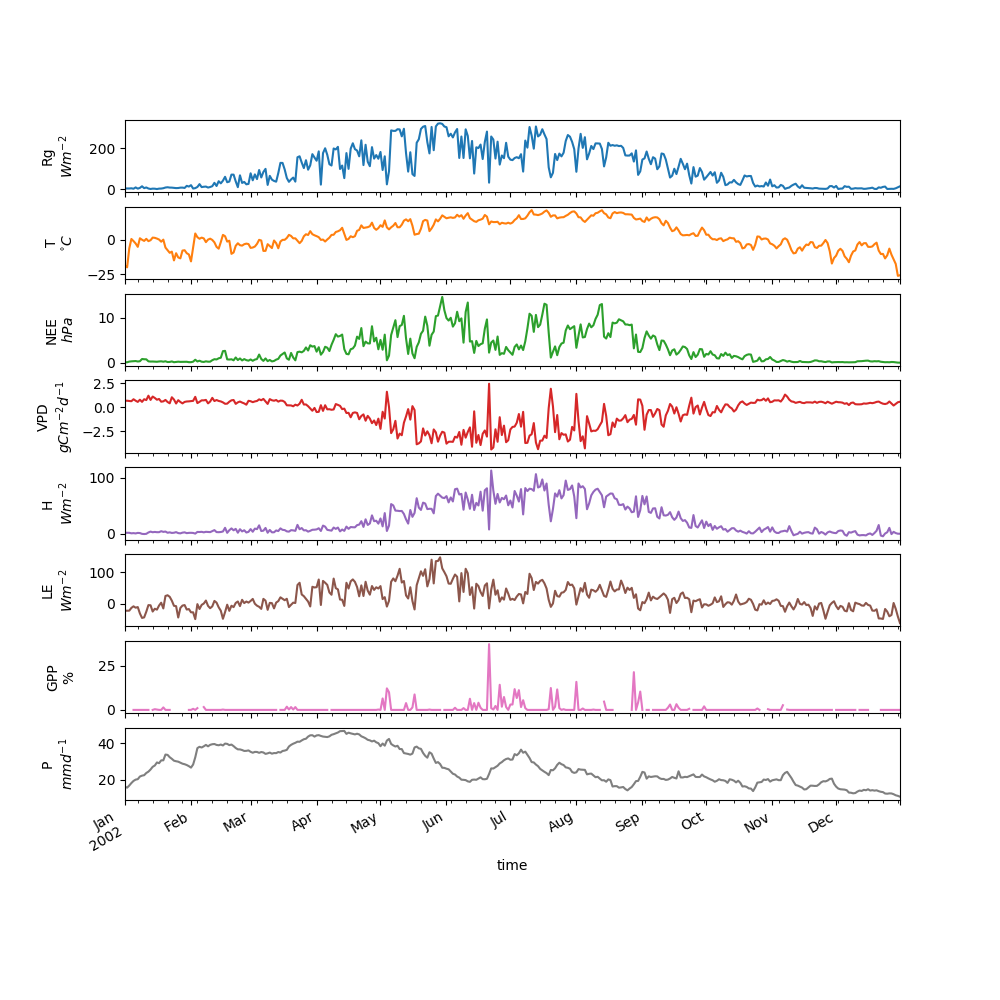

In [395]:
fig_ts=ts.loc[pd.Timestamp('2002-01-01'):pd.Timestamp('2002-12-31')].plot(subplots=True,figsize=(10,10),legend=False)
units=[r'$W m^{-2}$', r'$^{\circ}C$', r'$hPa$', r'$gC m^{-2} d^{-1}$', r'$W m^{-2}$',r'$W m^{-2}$', '%', r'$mm d^{-1}$','%']
[ax.set_ylabel(var+'\n'+u) for ax,var,u in zip(fig_ts,var_names+['GPP','P','SWC'],units)]
fig_ts=plt.gcf()
fig_ts.align_ylabels()

<IPython.core.display.Javascript object>


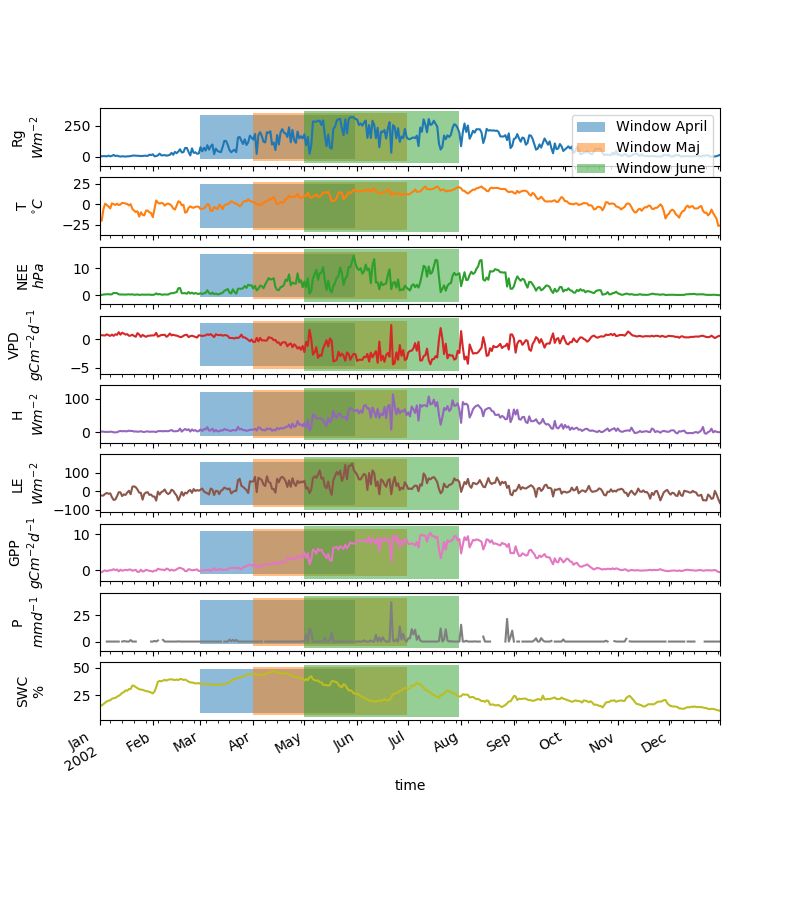

In [403]:
pl=ts.loc[pd.Timestamp('2002-01-01'):pd.Timestamp('2002-12-31')].plot(subplots=True,figsize=(8,9),legend=False)
units=[r'$W m^{-2}$', r'$^{\circ}C$', r'$hPa$', r'$gC m^{-2} d^{-1}$', r'$W m^{-2}$',r'$W m^{-2}$', r'$gC m^{-2} d^{-1}$', r'$mm d^{-1}$','%']
[ax.set_ylabel(var+'\n'+u) for ax,var,u in zip(pl,var_names+['GPP','P','SWC'],units)]

fig_ts=plt.gcf()
fig_ts.align_ylabels()

[ax.fill_betweenx(y=ax.get_ylim(),x1=pd.Timestamp('2002-03-01'),x2=pd.Timestamp('2002-05-31'),alpha=0.5) for ax in fig_ts.axes]
[ax.fill_betweenx(y=ax.get_ylim(),x1=pd.Timestamp('2002-04-01'),x2=pd.Timestamp('2002-06-30'),alpha=0.5) for ax in fig_ts.axes]
[ax.fill_betweenx(y=ax.get_ylim(),x1=pd.Timestamp('2002-05-01'),x2=pd.Timestamp('2002-07-31'),alpha=0.5) for ax in fig_ts.axes]

fig_ts.axes[0].legend(fig_ts.axes[0].collections,['Window April','Window Maj','Window June'])

In [404]:
fig_ts.savefig('/home/christopher/Documents/SecondPaper/Plots/Timeseries.pdf', bbox_inches='tight',dpi=300)

In [222]:
%matplotlib inline

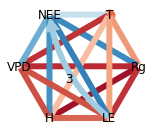

In [250]:
val_matrix=data[(data.Tower=='FI-Hyy.DD.1996.2014.nc') & (data.Year==2002) & (data.Season=='Maj')][np.linspace(0,215,216,dtype=int).astype(str)].values.reshape(nv,nv,-1)

graph=tp.plot_graph(
  #      fig_ax=(fig_inset,ax_inset),
        figsize=(2.5,2.5),
        val_matrix=val_matrix,
        link_matrix=val_matrix!=0,
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        arrow_linewidth=30,
        node_size=12,
     #   label_fontsize=15,
        node_label_size=12,
    #    curved_radius=0.5,
        link_label_fontsize=12,
        show_colorbar=False,
        )

In [251]:
graph[0].savefig('/home/christopher/Documents/SecondPaper/Plots/Network_withlaggedlinks.pdf', bbox_inches='tight',dpi=300)

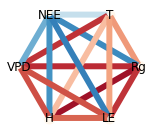

In [252]:
val_matrix[:,:,1:]=0
graph=tp.plot_graph(
  #      fig_ax=(fig_inset,ax_inset),
        figsize=(2.5,2.5),
        val_matrix=val_matrix,
        link_matrix=val_matrix!=0,
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        arrow_linewidth=30,
        node_size=12,
     #   label_fontsize=15,
        node_label_size=12,
    #    curved_radius=0.5,
        link_label_fontsize=9,
        show_colorbar=False,
        )

In [253]:
graph[0].savefig('/home/christopher/Documents/SecondPaper/Plots/Network_onlycontemporaneouslinks.pdf', bbox_inches='tight',dpi=300)

['Rg_mean',
 'T_mean',
 'NEE_mean',
 'VPD_mean',
 'H_mean',
 'LE_mean',
 'P_mean',
 'SWC_mean']

In [390]:
data[(data.Tower=='FI-Hyy.DD.1996.2014.nc') & (data.Year==2002) & (data.Season=='Maj')][[v+'_mean' for v in var_names+['GPP','P','SWC1']]]

Rg_mean     T_mean  NEE_mean  VPD_mean    H_mean   LE_mean  GPP_mean  \
3794  197.47575  10.412732 -1.848085  5.658716  55.46674  39.62121  5.247096   

        P_mean  SWC1_mean  
3794  1.416068  34.228081

Rg_mean     T_mean  NEE_mean  VPD_mean    H_mean   LE_mean  GPP_mean  \
3794  197.47575  10.412732  1.848085  5.658716  55.46674  39.62121  5.247096   

        P_mean  SWC1_mean  
3794  1.416068  34.228081

In [355]:
data[(data.Tower=='FI-Hyy.DD.1996.2014.nc') & (data.Year==2002) & (data.Season=='Maj')][['Bowenratio','IGBP', 'KoeppenGeigerGroup', 'lat','lon' ]]

Bowenratio IGBP  KoeppenGeigerGroup      lat     lon
3794    1.399925  ENF                 4.0  61.8475  24.295

In [ ]:
fig, ax = plt.subplots(3,1,sharey=True,figsize=(6.5,15))

for i,var,cmap,lim in zip([0,1,2],['NEE→LE:0','lat','lon'],['RdBu_r','twilight','twilight'],[(-1,1),(-90,90),(-180,180)]):
    p=ax[i].hexbin(data['T_mean'], data['P_mean'], C=data[var], cmap=cmap,vmin=lim[0],vmax=lim[1],label=var)
    ax[i].set_ylim(-1,20)
    bar=plt.colorbar(p,ax=ax[i])
    bar.set_label(var)

# temperature distribution of cluster 3

In [ ]:
sns.distplot

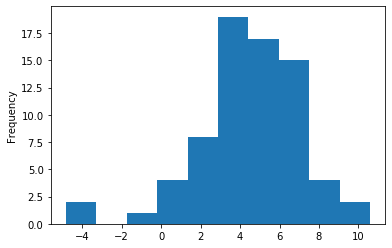

In [387]:
data[data['Clustering_TSNE_cont_links_agg_red_30']==31].T_mean.plot.hist()

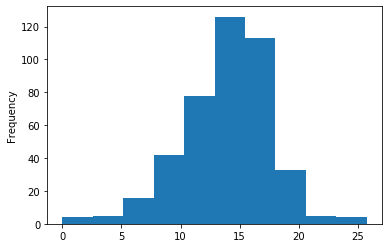

In [386]:
19

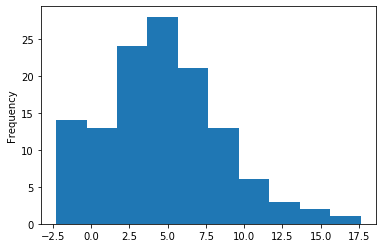

In [385]:
3

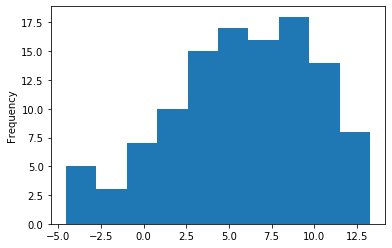

In [384]:
25

In [ ]:
pd.plotting.hi

## scatter T-P-NEE_LE

In [192]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
data

In [ ]:
%matplotlib inline

In [66]:
# chnage sign of NEE
data.loc[:,[link for link in data.keys() if 'NEE' in link]]*=-1# data.loc[:,[link for link in data.keys() if 'NEE' in link and '→' in link]].mul(-1)

data.loc[:,np.where(['NEE' in l for l in matrix.reshape(nv*nv*(tau_max-tau_min+1))])[0].astype(str)]*=-1 

<IPython.core.display.Javascript object>


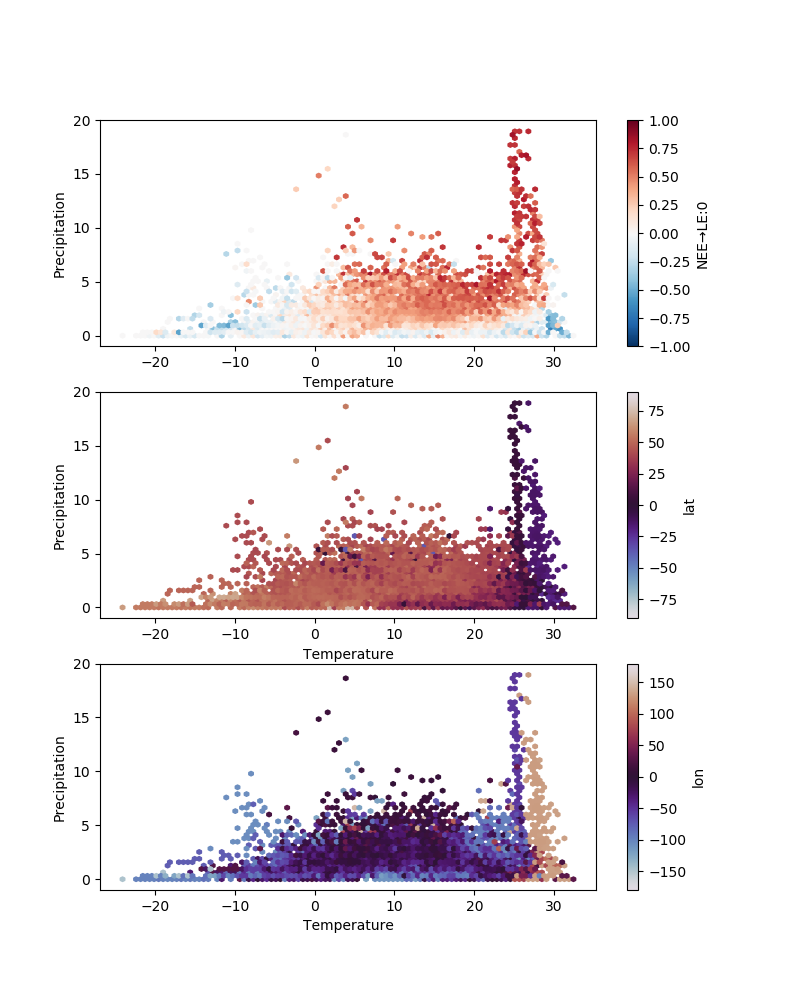

In [204]:
fig, ax = plt.subplots(3,1,sharey=True,figsize=(8,10))

for i,var,cmap,lim in zip([0,1,2],['NEE→LE:0','lat','lon'],['RdBu_r','twilight','twilight'],[(-1,1),(-90,90),(-180,180)]):
    p=ax[i].hexbin(data['T_mean'], data['P_mean'], C=data[var], cmap=cmap,vmin=lim[0],vmax=lim[1],label=var)
    ax[i].set_ylim(-1,20)
    bar=plt.colorbar(p,ax=ax[i])
    bar.set_label(var)
    ax[i].set_ylabel('Precipitation')
    ax[i].set_xlabel('Temperature')

    

In [206]:
fig.savefig('/home/christopher/Documents/SecondPaper/Plots/Scatter_P_T_NNE-LE.pdf', bbox_inches='tight',dpi=300)

In [391]:
%matplotlib notebook

<IPython.core.display.Javascript object>


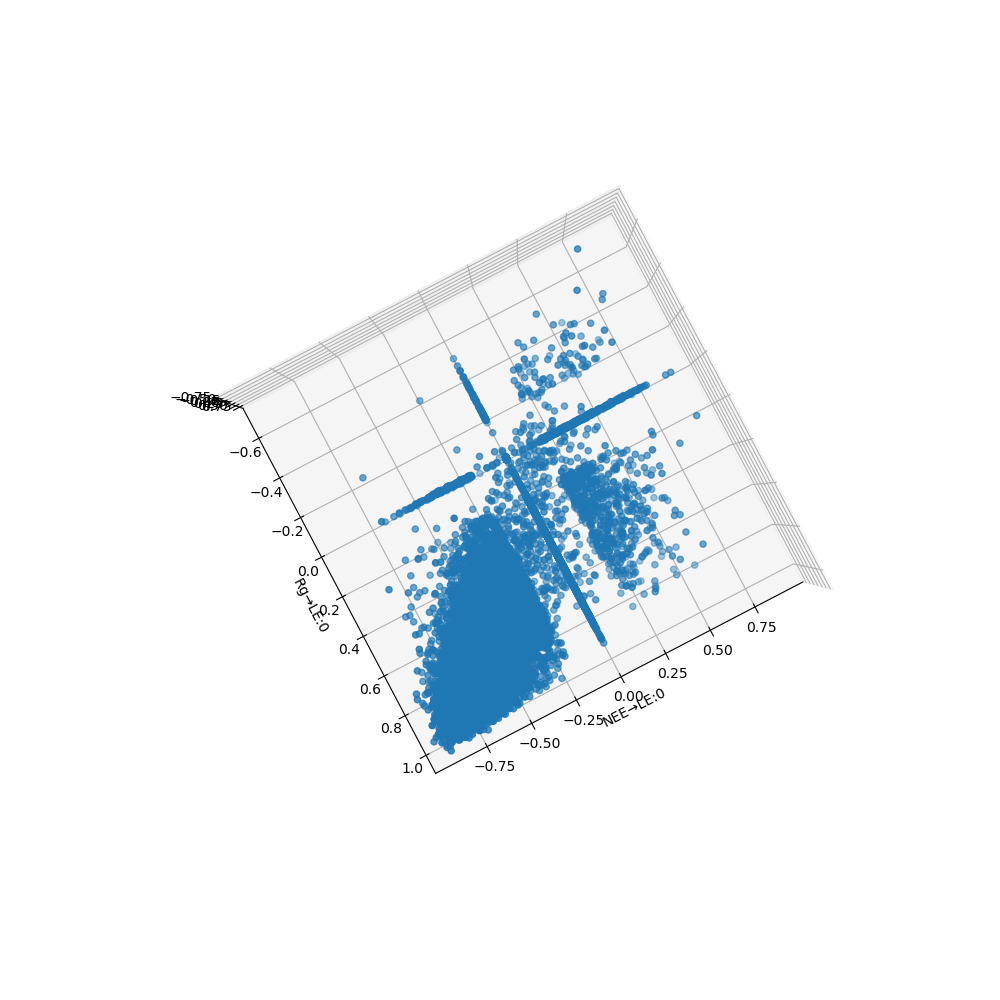

Text(0.5, 0, 'Rg→LE:0')

In [392]:
threedee = plt.figure(figsize=(10,10)).gca(projection='3d')
threedee.scatter(data['NEE→LE:0'], data['Rg→LE:0'], data['T→NEE:0'],)
threedee.set_xlabel('NEE→LE:0')
threedee.set_ylabel('Rg→LE:0')


In [190]:
data[data.T_mean<-10][['Tower','T_mean', 'Year','Season']]

Tower     T_mean         Year Season
1288   CA-Mer.DD.1998.2005.nc -12.925742  2003.000000    Jan
1300   CA-Mer.DD.1998.2005.nc -12.073792  2004.000000    Jan
1326   CA-NS1.DD.2001.2005.nc -17.732986  2003.000000    Feb
1327   CA-NS1.DD.2001.2005.nc -10.990241  2003.000000    Mar
1336   CA-NS1.DD.2001.2005.nc -13.604710  2003.000000    Dec
1337   CA-NS1.DD.2001.2005.nc -20.054974  2004.000000    Jan
1338   CA-NS1.DD.2001.2005.nc -16.447927  2004.000000    Feb
1348   CA-NS1.DD.2001.2005.nc -16.097525  2004.000000    Dec
1349   CA-NS1.DD.2001.2005.nc -18.473665  2005.000000    Jan
1350   CA-NS1.DD.2001.2005.nc -15.478304  2005.000000    Feb
1361   CA-NS2.DD.2001.2005.nc -20.173973  2002.000000    Jan
1362   CA-NS2.DD.2001.2005.nc -18.674496  2002.000000    Feb
1363   CA-NS2.DD.2001.2005.nc -12.859031  2002.000000    Mar
1371   CA-NS2.DD.2001.2005.nc -10.654742  2002.000000    Nov
1380   CA-NS2.DD.2001.2005.nc -15.679710  2003.000000    Dec
1381   CA-NS2.DD.2001.2005.nc -21.791338  2004.000000    Jan
1382   CA-NS2.DD.2001.2005.nc -18.328773  2004.000000    Feb
1383   CA-NS2.DD.2001.2005.nc -10.284878  2004.000000    Mar
1396   CA-NS3.DD.2001.2005.nc -20.494598  2002.000000    Jan
1397   CA-NS3.DD.2001.2005.nc -19.099665  2002.000000    Feb
1398   CA-NS3.DD.2001.2005.nc -13.360016  2002.000000    Mar
1403   CA-NS3.DD.2001.2005.nc -22.333017  2004.000000    Jan
1404   CA-NS3.DD.2001.2005.nc -18.830040  2004.000000    Feb
1405   CA-NS3.DD.2001.2005.nc -10.497238  2004.000000    Mar
1411   CA-NS3.DD.2001.2005.nc -18.655788  2004.000000    Dec
1412   CA-NS3.DD.2001.2005.nc -21.466702  2005.000000    Jan
1413   CA-NS3.DD.2001.2005.nc -18.299988  2005.000000    Feb
1423   CA-NS5.DD.2001.2005.nc -20.433400  2002.000000    Jan
1424   CA-NS5.DD.2001.2005.nc -19.017817  2002.000000    Feb
1425   CA-NS5.DD.2001.2005.nc -13.249096  2002.000000    Mar
...                       ...        ...          ...    ...
10234  CA-NS2.DD.2001.2005.nc -20.982655  2003.000000    Jan
10235  CA-NS2.DD.2001.2005.nc -18.501635  2003.000000    Feb
10236  CA-NS2.DD.2001.2005.nc -11.571955  2003.000000    Mar
10246  CA-NS3.DD.2001.2005.nc -21.431439  2003.666667    Jan
10247  CA-NS3.DD.2001.2005.nc -18.743231  2003.666667    Feb
10248  CA-NS3.DD.2001.2005.nc -11.127710  2003.666667    Mar
10256  CA-NS5.DD.2001.2005.nc -13.724356  2002.666667    Dec
10257  CA-NS5.DD.2001.2005.nc -20.650822  2003.666667    Jan
10258  CA-NS5.DD.2001.2005.nc -17.968008  2003.666667    Feb
10259  CA-NS5.DD.2001.2005.nc -10.509694  2003.666667    Mar
10267  CA-NS6.DD.2001.2005.nc -13.275087  2002.500000    Dec
10268  CA-NS6.DD.2001.2005.nc -20.414848  2003.500000    Jan
10269  CA-NS6.DD.2001.2005.nc -17.775217  2003.500000    Feb
10270  CA-NS6.DD.2001.2005.nc -10.393015  2003.500000    Mar
10281  CA-Qcu.DD.2001.2006.nc -10.483254  2003.000000    Dec
10282  CA-Qcu.DD.2001.2006.nc -16.638331  2004.000000    Jan
10283  CA-Qcu.DD.2001.2006.nc -13.668112  2004.000000    Feb
10299  CA-Qfo.DD.2003.2010.nc -11.344046  2006.000000    Dec
10300  CA-Qfo.DD.2003.2010.nc -16.639095  2007.000000    Jan
10301  CA-Qfo.DD.2003.2010.nc -13.284502  2007.500000    Feb
10571  FI-Kaa.DD.2000.2006.nc -10.165506  2002.250000    Feb
10582  FI-Kaa.DD.2000.2006.nc -10.127302  2003.500000    Jan
10583  FI-Sod.DD.2001.2014.nc -10.499039  2008.285714    Feb
10594  FI-Sod.DD.2001.2014.nc -12.588747  2008.142857    Jan
11198  US-Prr.DD.2010.2014.nc -18.699482  2011.333333    Dec
11199  US-Prr.DD.2010.2014.nc -18.487577  2012.000000    Jan
11206  US-Prr.DD.2010.2014.nc -15.725956  2012.000000    Nov
11207  US-Prr.DD.2010.2014.nc -17.677834  2012.500000    Feb
11209  US-Prr.DD.2010.2014.nc -12.439989  2013.000000    Mar
11271  US-Syv.DD.2001.2014.nc -11.644213  2006.333333    Jan

[172 rows x 4 columns]

In [ ]:
fig.axes[0]=ts_plot[1][0]

In [ ]:
fig.axes

In [ ]:
ts_plot

In [ ]:
fig

In [ ]:
data.DataPolicy.unique()

In [ ]:
data[data.DataPolicy=='Fair_Use'].Tower.unique()


In [ ]:
29
34
54
60
65
70
HU-Bug
75
76
84
95
103
50
SE-Nor
106
US-Aud
US-Bo1
US-FPe
117
134
134
134

In [ ]:
data.keys().values

In [ ]:
data[data.PeakGrowingMonth_Year==True].groupby(['IGBP']).plot.scatter(x='P_mean',y='Connectivity_NEE')

In [ ]:
ax=sns.lmplot(data=data[data.PeakGrowingMonth_Year==True],x='P_mean',y='Connectivity_NEE',hue='Tower',row='IGBP')
ax.set(ylim=(-5,8))
ax.set(xlim=(-1,20))

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(15,15),gridspec_kw=dict(hspace=.2,wspace=0.1))



for i,igbp in enumerate(np.sort(data.IGBP.unique().astype(str))):
    #temp=np.where(data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].groupby('Tower').count()['P_mean_norm_deviation_from_season_median']>=4)
    #temp_tower=data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].Tower.unique()[temp]
   # indices=[i for i in data.index if data.loc[i,'Tower'] in temp_tower]
    for t in data[data.IGBP==igbp].Tower.unique():
        
        indices=data[(data.PeakGrowingMonth==True) & (data.IGBP==igbp) & (data.Tower==t)].loc[:index_mean_networks].index
        if indices.notna().sum()<4:
            continue
        sns.regplot(data=data.loc[indices], x= 'P_mean', y='Connectivity_NEELE',ax= fig.axes[i])
    fig.axes[i].set_ylim(-1.5,7)
    fig.axes[i].set_title(igbp)
    fig.axes[i].set_xlabel('')
    [a.set_xticks([]) for a in ax[:-1,:].reshape(-1) ];
    [a.set_yticks([]) for a in ax[:,1:].reshape(-1) ]
    [a.set_ylabel('') for a in ax[:,1:].reshape(-1) ]
    ax[-1,2].set_xlabel('P_mean_norm_deviation_from_season_median')


In [ ]:
np.sort(data.IGBP.unique().astype(str))

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(15,15),gridspec_kw=dict(hspace=.2,wspace=0.1))



for i,igbp in enumerate(np.sort(data.IGBP.unique().astype(str))):
    #temp=np.where(data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].groupby('Tower').count()['P_mean_norm_deviation_from_season_median']>=4)
    #temp_tower=data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].Tower.unique()[temp]
   # indices=[i for i in data.index if data.loc[i,'Tower'] in temp_tower]
    for t in data[data.IGBP==igbp].Tower.unique():
        
        indices=data[(data.DistanceClusterCentersToCluster0==0) & (data.IGBP==igbp) & (data.Tower==t)].loc[:index_mean_networks].index
        if indices.notna().sum()<4:
            continue
        sns.regplot(data=data.loc[indices], x= 'P_mean', y='Connectivity_NEELE',ax= fig.axes[i])
    fig.axes[i].set_ylim(-1.5,7)
    fig.axes[i].set_title(igbp)
    fig.axes[i].set_xlabel('')
 #   [a.set_xticks([]) for a in ax[:-1,:].reshape(-1) ];
  #  [a.set_yticks([]) for a in ax[:,1:].reshape(-1) ]
   # [a.set_ylabel('') for a in ax[:,1:].reshape(-1) ]
    ax[-1,2].set_xlabel('P_mean_norm_deviation_from_season_median')


In [ ]:
indices=data[(data.DistanceClusterCentersToCluster0==0) & (data.IGBP!='CRO')].loc[:index_mean_networks].index


In [ ]:
test=data.loc[indices]

In [ ]:
test['Tower'].value_counts().index[0:20]

In [ ]:
sns.swarmplot(data=data.loc[indices],x='IGBP',y='P_mean')

In [ ]:
sns.swarmplot(data=data.loc[indices],x='IGBP',y='GPP_mean')

In [ ]:
sns.swarmplot(data=data.loc[indices],x='IGBP',y='Connectivity_NEE')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,15),gridspec_kw=dict(hspace=.2,wspace=0.1))



for i,igbp in enumerate(np.sort(test.IGBP.unique().astype(str))):
    #temp=np.where(data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].groupby('Tower').count()['P_mean_norm_deviation_from_season_median']>=4)
    #temp_tower=data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].Tower.unique()[temp]
   # indices=[i for i in data.index if data.loc[i,'Tower'] in temp_tower]
    for t in test['Tower'].value_counts().index[0:15]:
        
        indices=data[(data.DistanceClusterCentersToCluster0==0) & (data.IGBP==igbp) & (data.Tower==t)].loc[:index_mean_networks].index
        if indices.notna().sum()<4:
            continue
        sns.regplot(data=data.loc[indices], x= 'P_mean', y='Connectivity_NEELE',ci=0,label=t,ax=ax)
    ax.legend()
    ax.set(ylim=(2,6))
    ax.set(xlim=(0,20))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,15),gridspec_kw=dict(hspace=.2,wspace=0.1))



for i,igbp in enumerate(np.sort(test.IGBP.unique().astype(str))):
    #temp=np.where(data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].groupby('Tower').count()['P_mean_norm_deviation_from_season_median']>=4)
    #temp_tower=data[(data.PeakGrowingMonth==True) & (data.KoeppenGeigerSpec==igbp)].Tower.unique()[temp]
   # indices=[i for i in data.index if data.loc[i,'Tower'] in temp_tower]
    indices=data[(data.DistanceClusterCentersToCluster0==0) & (data.IGBP==igbp)].loc[:index_mean_networks].index
    if indices.notna().sum()<4:
        continue
    sns.regplot(data=data.loc[indices], x= 'P_mean', y='Connectivity_NEELE',ci=0,label=igbp,ax=ax)
    ax.legend()
    ax.set(ylim=(2,6))
    ax.set(xlim=(0,20))

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=data.loc[indices],x='P_mean',y='Connectivity_NEELE',hue='Tower')


In [ ]:
j=50
dimRedType='TSNE_cont_links_agg_red_30' #'PCA_meta_' #'tSNE%s'%j
dimReddim1='1'
dimReddim2='2'
num=len(var_names)
fig2, ax2 = plt.subplots(ncols=3, nrows=np.ceil(num/3).astype(int),gridspec_kw=dict(hspace=0.,wspace=0.),figsize=(15,np.ceil(num/3).astype(int)*5))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for i,var in enumerate(var_names):
    color=data.loc[:12545][[link for link in cont_links_agg_red if var in link]].mean(axis=1)
    ax=fig2.axes[i]
    sc= ax.scatter(data.loc[:12545,dimRedType+dimReddim1],data.loc[:12545,dimRedType+dimReddim2],c=color,s=0.1,cmap='coolwarm',alpha=1,edgecolors=None,vmin=-0.5,vmax=0.5)
   # a.set_ylabel(matrix.reshape(nv*nv*6)[int(dcor_vec_sort[i])])
    text=var
    if text[0:2]!='Rg':
        text=text.replace('→',r'$-$')
    ax.annotate(text,(0.2,0.98),xycoords='axes fraction', va="top", ha="center")
 #   ax.annotate(round(df['Ranking'].values[i],2),(0.8,0.98),xycoords='axes fraction', va="top", ha="center")

  #  ax.set_facecolor('gray')  
    ax.tick_params(labelbottom=False, labelleft=False)
#    axins = inset_axes(ax,
 #                  width="5%",  # width = 5% of parent_bbox width
  #                 height="100%",  # height : 50%
   #                loc='lower right',
    #               bbox_to_anchor=(0, 0., 1, 1),
     #              bbox_transform=ax.transAxes,
      #             borderpad=0,
       #            )
    #cbar=fig3.colorbar(sc, cax=axins)
  #  cbar.set_label(dimensions[i])
        
ax_cbar=fig2.add_axes([0.3, 0.08, 0.4, 0.02])
cbar_cbar=fig2.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5), cmap='coolwarm'), cmap='coolwarm', cax=ax_cbar,ax=fig2.axes, orientation='horizontal')
#cbar_cbar.set_ticks(np.arange(1, 13, 1))
#cbar_cbar.set_ticklabels(np.arange(1, 13, 1))
cbar_cbar.set_label('mean MCI cross-dependence value')
 
#cbar=fig2.colorbar(sc, cax=axins, orientation='horizontal')
  #  cbar.set_label(color[i])
#fig2.tight_layout()
#format_axes(fig)
plt.show()